# Global Settings

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.stats import hmean
from scipy.stats import skewnorm
from scipy.special import binom, comb
import scipy.special
import pickle
import re
import os
from functools import partial
import math
from matplotlib.markers import MarkerStyle
from master_utilities import *

CANONICAL=False
def calculate_covariance_total(means):
    #calculate covariance worst case for the beroulli random variable assumption that byte i failing results in byte j>i failing
    aggregate_covariance=0
    for i in range(len(means)):
        for j in range(i,len(means)):
            aggregate_covariance+=2*means[i]*(1-means[j])
    return aggregate_covariance

def plot_viterbi_rates_vs_length(algorithms,style_dictionary,xlim,ylim,plot_individual=False,baseline_fail=True,save_name=None):
    bonito_error_rates={}
    if plot_individual:fig,ax2=plt.subplots(1,1,figsize=(3, 2), dpi=120,constrained_layout=True)
    else: fig=None
    colors=["red","black","green"]
    for a_index,a in enumerate(algorithms):
        data=a[1]
        dna_error_rates={}
        row_index=0
        print(os.path.split(a[0]))
        for index,row in data.iterrows():
            i = int(re.search("strand_?([0-9]+)(_|\.)",row["experiment_path"]).group(1))
            #print(i)
            dna_error_rates[i]={}
            baseline = data[data.experiment_path.str.match(".*strand{}(_|\.).*".format(i))]
            if baseline_fail:
                baseline_fail_strands =baseline["total_strands_analyzed"].iloc[0]-baseline["payload::hedges::total_strands"].iloc[0]
                total_strands=baseline["total_strands_analyzed"].iloc[0]
            else: 
                baseline_fail_strands=0
                total_strands = baseline["payload::hedges::total_strands"].iloc[0]
                
            baseline_percent = (baseline["payload::hedges::total_errors"].iloc[0]+baseline_fail_strands)/total_strands
            dna_error_rates[i]["total_errors"]=dna_error_rates[i].get("total_errors",np.zeros(len(baseline["payload::hedges::total_errors"].iloc[0])))+(baseline["payload::hedges::total_errors"].iloc[0]+baseline_fail_strands)
            dna_error_rates[i]["total_strands"]=dna_error_rates[i].get("total_strands",0) + total_strands
            dna_error_rates[i]["total_strands_correctly_decoded"]= dna_error_rates[i].get("total_strands_correctly_decoded",0) +baseline["payload::hedges::correct_strands"].iloc[0]

            mean = (dna_error_rates[i]["total_errors"]/dna_error_rates[i]["total_strands"])[:]
            error = 1.96*np.sqrt(mean*(1-mean)/dna_error_rates[i]["total_strands"])
            #print(error)
            if row_index!=0:
                label=''
            else:
                label=a[0]
            if "Full" in a[0]:zorder=1
            elif "Half" in a[0]: zorder=2
            else: zorder=3
            if fig!=None:
                print("{} {} {}".format(a[0],i,mean[2:8]))
                ax2.plot(mean,label=label,color=colors[a_index%len(colors)],linewidth=1,zorder=zorder)
                ax2.fill_between(range(len(mean)),mean-error,mean+error,color=colors[a_index%len(colors)],alpha=0.1,zorder=0,linewidth=0)

            row_index+=1
        if fig!=None:
            ax2.set_ylim([0,0.02])
            ax2.legend(fontsize=6,loc="upper left",labelspacing=0.2)
            ax2.set_title("Individual Strand Byte Error Rates",fontsize=10)
            ax2.set_xlabel("Byte Position",fontsize=8)
            ax2.set_ylabel("Average Byte Error Rate",fontsize=8)
            ax2.xaxis.set_tick_params(labelsize=8)
            ax2.yaxis.set_tick_params(labelsize=8)
            if save_name:
                fig.savefig(save_name,dpi=1200)
        bonito_error_rates[a[0]]=dna_error_rates
    average_error_rates={}
    for b in bonito_error_rates:
        strands= bonito_error_rates[b]
        total_errors = np.zeros(len(strands[list(strands.keys())[0]]["total_errors"].copy()))
        total_strands = 0
        total_variance=None
        encoded_strands=0
        aggregate_covariance=0
        arithmetic_strand_mean=None
        total_correct_strands=0
        for s in strands:
            total_errors += strands[s]["total_errors"]
            total_strands+= strands[s]["total_strands"]
            total_correct_strands+=strands[s]["total_strands_correctly_decoded"]
            encoded_strands+=1
            strand_mean = strands[s]["total_errors"]/strands[s]["total_strands"]
            if arithmetic_strand_mean is None: arithmetic_strand_mean=strand_mean.copy()
            else: arithmetic_strand_mean+=strand_mean
            aggregate_covariance+=calculate_covariance_total(strand_mean)/strands[s]["total_strands"]
            strand_variance = strand_mean*(1-strand_mean)/(strands[s]["total_strands"])
            if total_variance is None:total_variance=strand_variance.copy()
            else:total_variance+=strand_variance
        overall_variance=(np.sum(total_variance)+aggregate_covariance)/((encoded_strands**2)*len(total_variance)**2)
        total_variance=total_variance/encoded_strands**2
        bonito_error_rates[b]["Total"] = arithmetic_strand_mean/encoded_strands #total_errors/total_strands
        bonito_error_rates[b]["Alg Error"]= 1.96*np.sqrt(total_variance)
        bonito_error_rates[b]["Overall Mean"]=np.mean(bonito_error_rates[b]["Total"][2:])
        bonito_error_rates[b]["Overall Error"]=1.96*np.sqrt(overall_variance)
        print("{} -- Mean {} Error {}".format(b, bonito_error_rates[b]["Overall Mean"], bonito_error_rates[b]["Overall Error"]))
        print("Percent of strands correctly decoded {}".format(total_correct_strands/total_strands))

        average_error_rates[b]=bonito_error_rates[b]["Total"][2::]
    if style_dictionary is None: return bonito_error_rates,average_error_rates
    algs=[_[0] for _ in algorithms]
    for a in algs:
        error_rates = bonito_error_rates[a]
        for s_i,strand in enumerate(error_rates):
            if strand!="Total": 
                continue
                plot_rate = error_rates[strand]["total_errors"]/error_rates[strand]["total_strands"]
            else:
                #print(a)
                #print(np.mean(error_rates["Total"][2::]))
                plot_rate = error_rates["Total"]
                error = error_rates["Alg Error"] 
            label=style_dictionary[a]["label"]
            ax=style_dictionary[a]["ax"]
            ax1=ax
            ax.plot(range(len(plot_rate)),plot_rate,marker=style_dictionary[a]["marker"],color=style_dictionary[a]["color"],markersize=3,linewidth=1,markevery=4,
                    label=label,zorder=10)
            ax.fill_between(range(len(plot_rate)),plot_rate-error,plot_rate+error,color=style_dictionary[a]["color"],zorder=0,alpha=0.4)
    ax1.set_xlabel("Byte Position",fontsize=8)
    ax1.set_ylabel("Error Rate",fontsize=8)
    ax1.xaxis.set_tick_params(labelsize=8)
    ax1.yaxis.set_tick_params(labelsize=8)
    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    ax1.set_title("Byte Error Rate vs. Position",fontsize=10)
    ax1.legend(fontsize=8)
    plt.show()
    return bonito_error_rates,average_error_rates

# Load Data

In [2]:
dna_main_df = pd.read_pickle("231220_main_dna.pickle")
#dna_main_df = pd.read_pickle("qscore_experiments.pickle")
dna_df_dict=separate_master_data_frame(dna_main_df,None)

#dna hard decoding
dna_production_basecall = dna_df_dict["ont"]
dna_ctc_basecall= dna_df_dict["ctc"]
#rna hard decoding
rna_production_basecall_baseline = pd.read_pickle("231220_rna_production_algorithm.pickle")
rna_production_basecall=rna_production_basecall_baseline[rna_production_basecall_baseline["encoder::filter_upper_length"]!=2300].drop(columns=["encoder::filter_upper_length"])
rna_rodan_basecall = pd.read_pickle("231220_rna_rodan_algorithm.pickle")
rna_production_basecall_no_chimeric =  rna_production_basecall_baseline[rna_production_basecall_baseline["encoder::filter_upper_length"]==2300]

# HEDGES baseline decoding

## Error Rates for Basecall Algortihms


========231206_dna_datastorage_1667_batch_full_1667========
1:0.04724321540933885
2:0.04940755336248692
14:0.05772695667172186
15:0.055415718063635905
16:0.06740086917601859
17:0.05748906484954879
18:0.05901866867169717
231206_dna_datastorage_1667_batch_full_1667:0.05625937685528685
========231206_dna_datastorage_1667_batch_full_1667========
1:0.06406034600389864
2:0.06405225847169516
14:0.07814573209421666
15:0.07637654011543057
16:0.09218500627078392
17:0.07927121285737758
18:0.07803908564667306
231206_dna_datastorage_1667_batch_full_1667:0.07599070692324081
break
========231206_dna_datastorage_1667_batch_full_1667========
1:0.08947204166666667
2:0.094951875
231206_dna_datastorage_1667_batch_full_1667:0.09221195833333333
break
========231206_dna_datastorage_1667_batch_full_1667========
1:0.0967035910871716
2:0.09745111029684819
231206_dna_datastorage_1667_batch_full_1667:0.09707219778637595


/tmp/ipykernel_21133/1157555938.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5, 2), dpi=120)


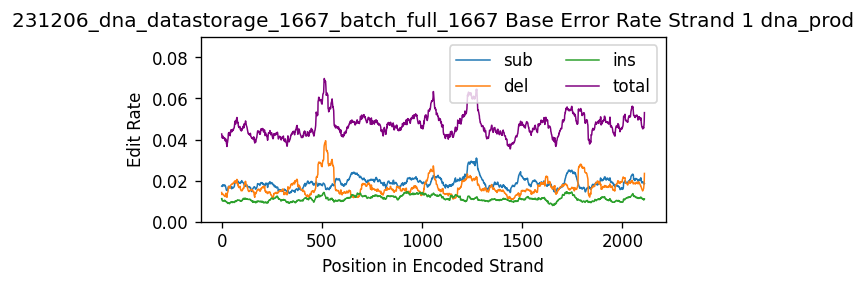

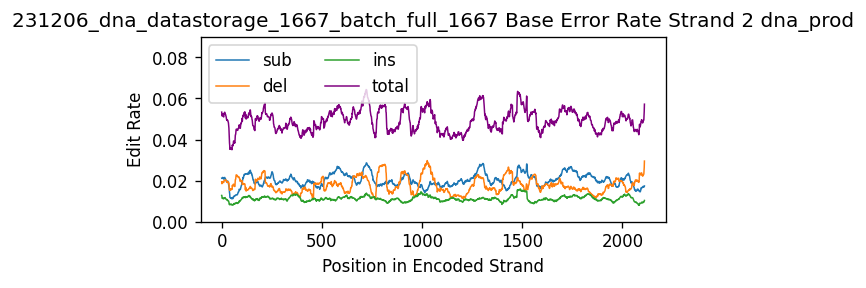

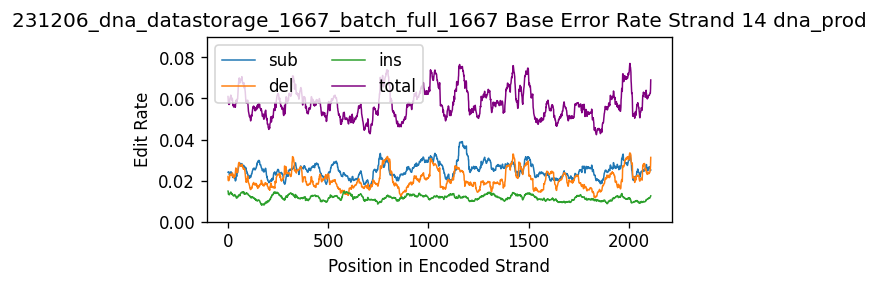

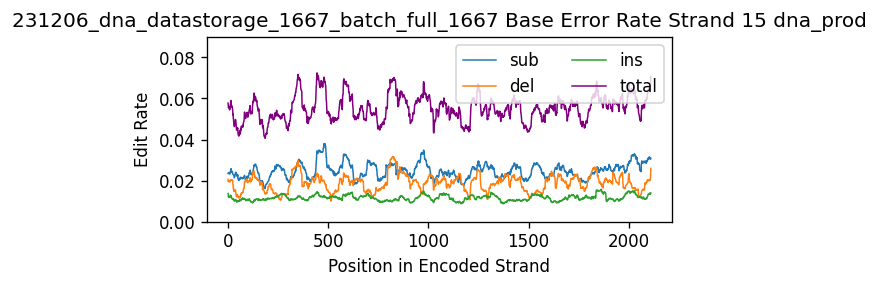

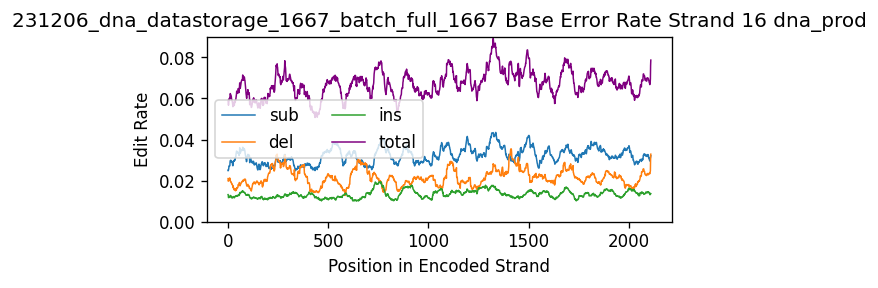

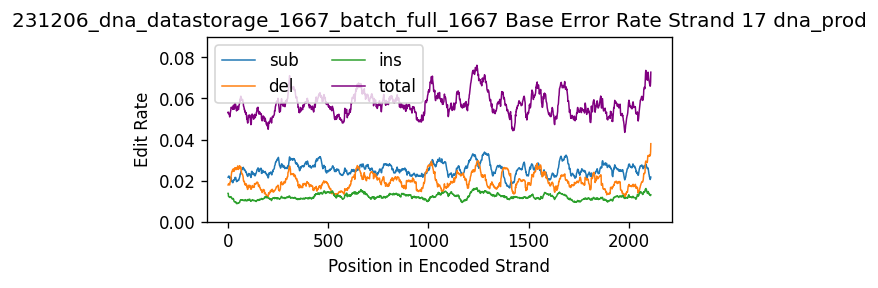

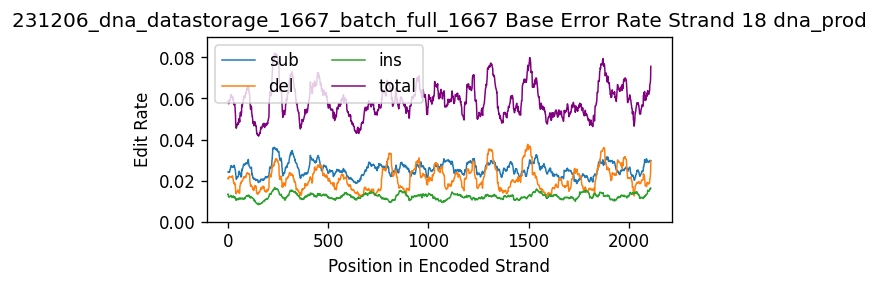

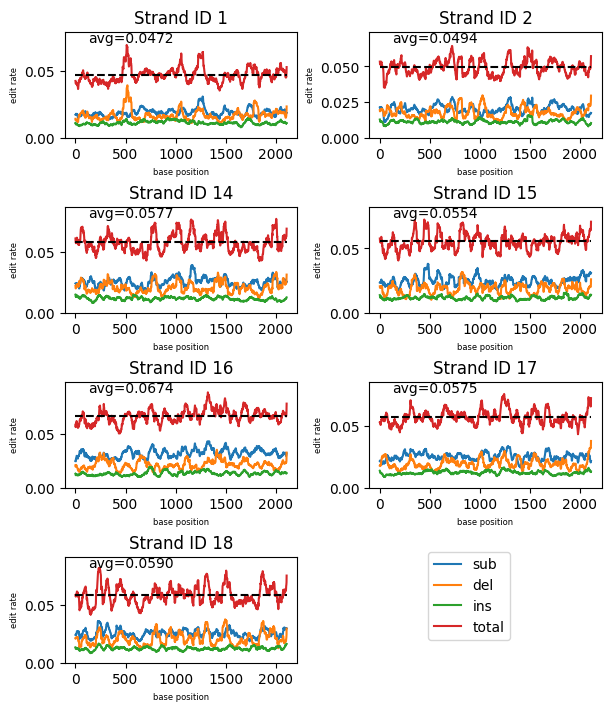

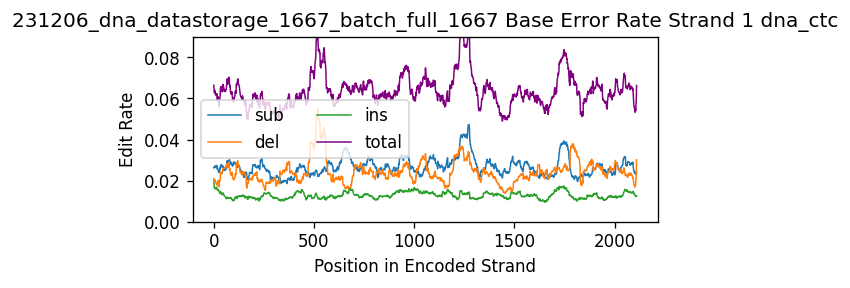

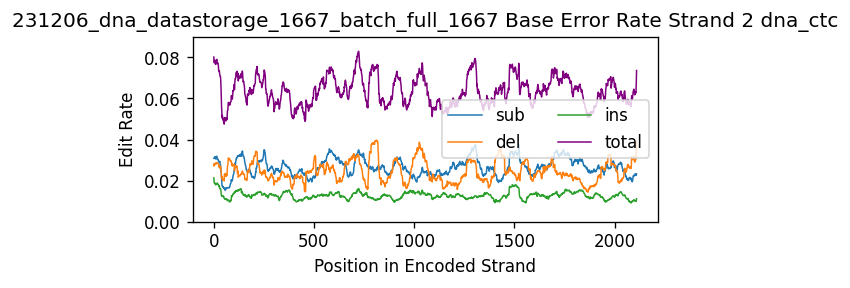

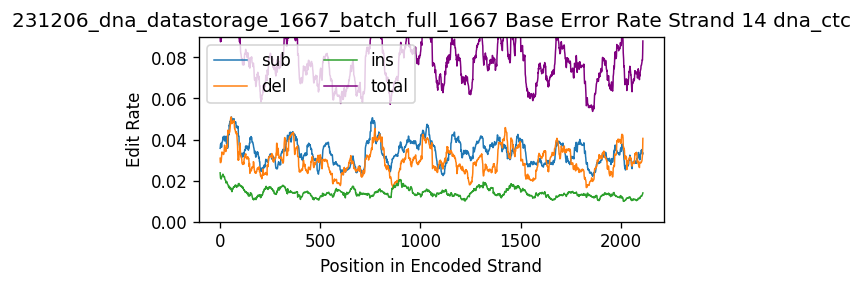

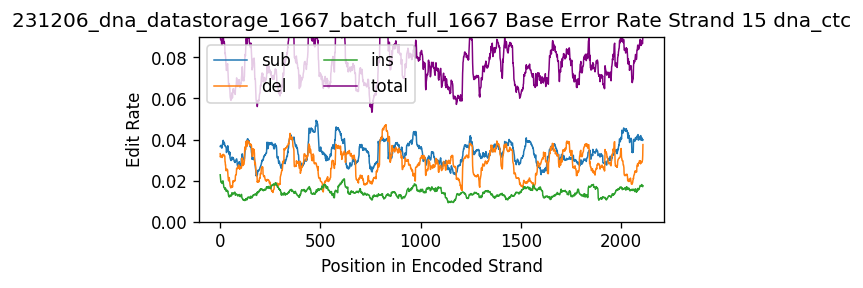

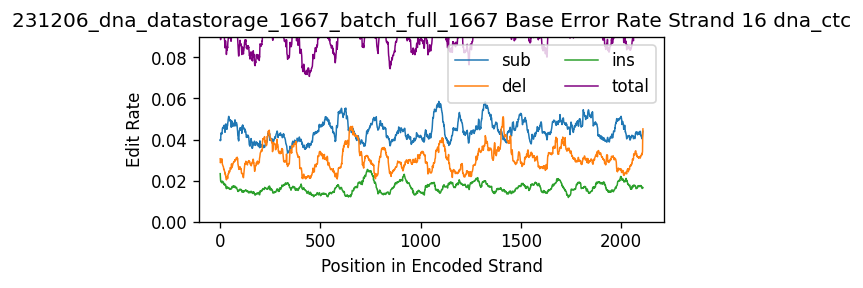

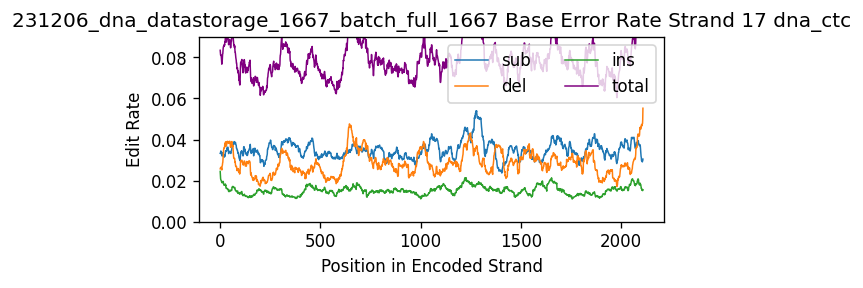

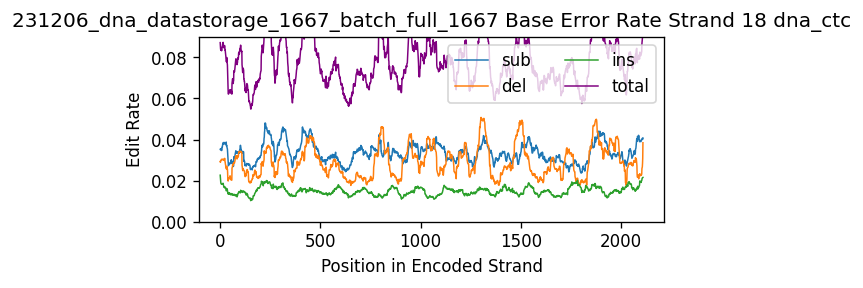

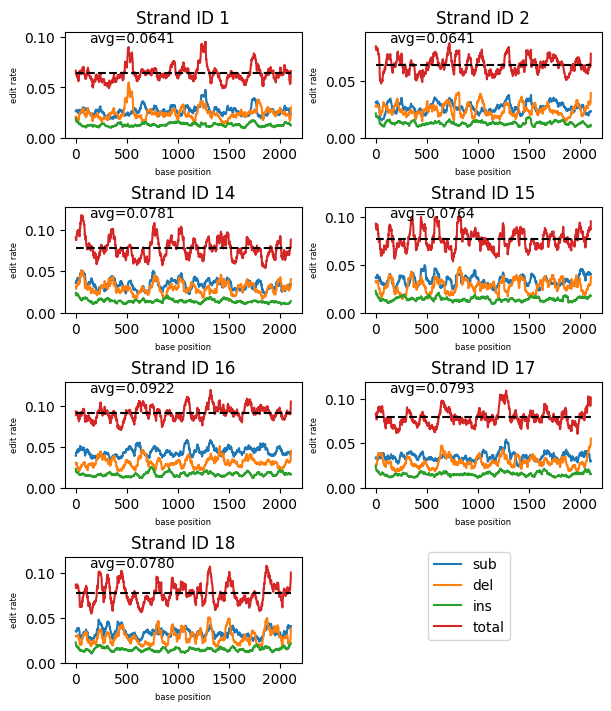

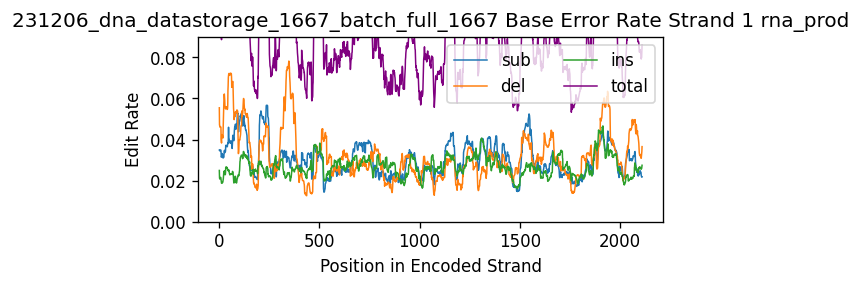

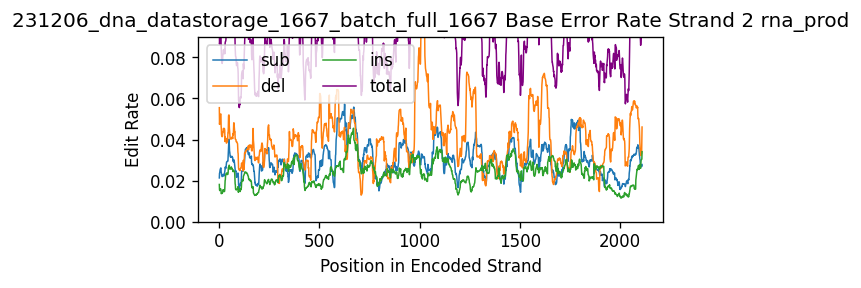

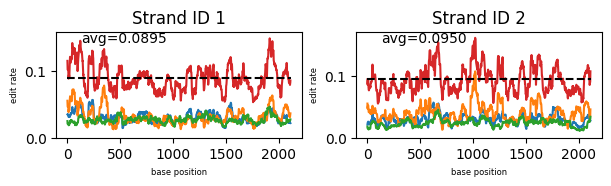

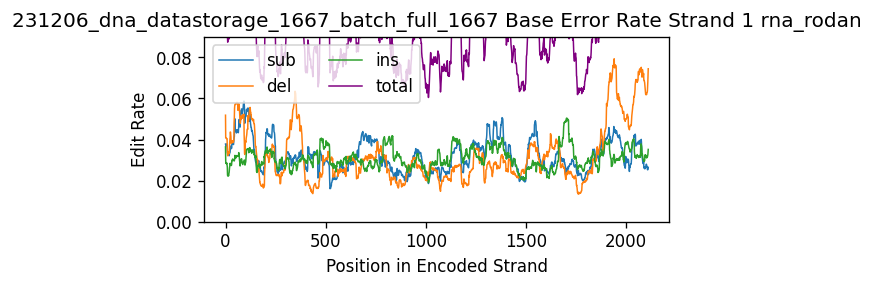

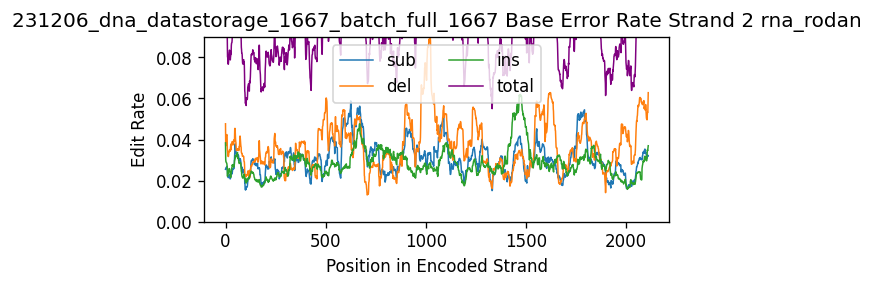

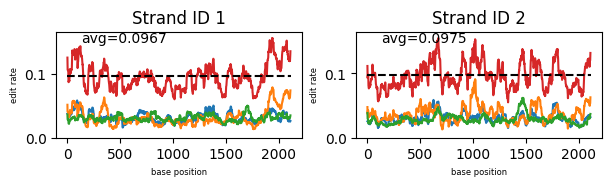

In [3]:
#Break Down edit distance into different operations
edit_window=50


algorithms = [
("Production DNA Basecall",dna_production_basecall,2000,"dna_prod"),
("CTC DNA Basecall",dna_ctc_basecall,2000,"dna_ctc"),
("Production RNA Basecall",rna_production_basecall,2000,"rna_prod"),
("Rodan RNA Basecall", rna_rodan_basecall,0,"rna_rodan")
]
target_batches=["231206_dna_datastorage_1667_batch_full_1667",
                #"231206_dna_datastorage_1667_batch_quarter_1667",
                #"231206_dna_datastorage_1667_batch_half_1667",
                #"231207_dna_datastorage_others_fl_batch_3333_fl",
                #"231207_dna_datastorage_others_fl_batch_1250_fl",
                #"231207_dna_datastorage_others_fl_batch_5000_fl"
               ]

for a in algorithms:
    data = a[1]
    for batch in target_batches:
        break_fl=False
        edit_df = data[(data.experiment_path.str.match(".*{batch}.*.fastq".format(batch=batch))) & (data["encoder::hedges_guesses"]==100000)]
        if edit_df.empty:
            edit_df = data[(data["encoder::hedges_guesses"]==100000)& (data["encoder::filter_lower_length"]==a[2])]
            print("break")
            break_fl=True
        sub_fig=[]
        del_fig=[]
        ins_fig=[]
        total_fig=[]
        strandIDs=[]
        labels=[]
        figs=[]
        avg=[]
        batch_error_rate_num=0
        batch_error_rate_denom=0
        edit_df=edit_df.sort_values(by="experiment_path",key=lambda x: experiment_to_strandID(x))
        print("========{}========".format(batch))
        for index,row in edit_df.iterrows():
            strandID = re.search("strand_?([0-9]+)",row["experiment_path"]).group(1)
            total_strands=row["payload::ed_total_strands"]
            total_edit_errors=row["payload::total_edit_errors"]
            total_edit_errors_rate = total_edit_errors/total_strands
            average_total_edit_rate=np.sum(total_edit_errors)/(total_strands*len(total_edit_errors))
            batch_error_rate_num+=np.sum(total_edit_errors)
            batch_error_rate_denom+=(total_strands*len(total_edit_errors))
            dump_name="{}_strand{}_variable_error_rate.pickle".format(a[3],strandID)
            insertion =row["payload::insertion_edit_errors"]/total_strands
            deletion = row["payload::deletion_edit_errors"]/total_strands
            substitution=row["payload::substitution_edit_errors"]/total_strands
            window_edit_rate=rolling_arithmetic_mean(total_edit_errors_rate,edit_window)
            print("{}:{}".format(strandID,average_total_edit_rate))
            sub_window=rolling_arithmetic_mean(substitution,edit_window)
            del_window=rolling_arithmetic_mean(deletion,edit_window)
            ins_window=rolling_arithmetic_mean(insertion,edit_window)
            labels.append("Strand "+strandID)
            sub_fig.append(sub_window)
            ins_fig.append(ins_window)
            del_fig.append(del_window)
            strandIDs.append(strandID)
            avg.append(average_total_edit_rate)
            total_fig.append(window_edit_rate)
            plt.figure(figsize=(5, 2), dpi=120)
            plt.title("{} Base Error Rate Strand {} {}".format(batch,strandID,a[3]))
            plt.ylabel("Edit Rate")
            plt.xlabel("Position in Encoded Strand")
            plt.ylim([0,0.09])
            plt.plot(range(len(sub_window)),sub_window,linewidth=0.9,label="sub")
            plt.plot(range(len(del_window)),del_window,linewidth=0.9,label="del")
            plt.plot(range(len(ins_window)),ins_window,linewidth=0.9,label="ins")
            plt.plot(range(len(window_edit_rate)),window_edit_rate,linewidth=0.9,label="total",color="purple")
            plt.legend(ncol=2)
        print("{}:{}".format(batch,batch_error_rate_num/batch_error_rate_denom))
        nrows=(len(total_fig)//2)+len(total_fig)%2
        fig,ax=plt.subplots(nrows=(len(total_fig)//2)+len(total_fig)%2,ncols=2,figsize=(6, nrows*1.75), dpi=100,constrained_layout=True,squeeze=False)
        for plot_index,(ID,sub,ins,deletion,total,average) in enumerate(sorted(zip(strandIDs,sub_fig,ins_fig,del_fig,total_fig,avg),key=lambda x: int(x[0]))):
            row=plot_index//2
            col=plot_index%2
            l1,=ax[row,col].plot(sub,label="sub")
            l2,=ax[row,col].plot(deletion,label="del")
            l3,=ax[row,col].plot(ins,label="ins")
            l4,=ax[row,col].plot(total,label="total")
            ax[row,col].hlines(average,0,len(total),color="black",linestyle="dashed")
            ax[row,col].set_ylim([0,max(total)+0.01])
            ax[row,col].set_title("Strand ID {}".format(ID))
            ax[row,col].text(0.1,0.9,"avg={:.4f}".format(average),transform=ax[row,col].transAxes)
            ax[row,col].set_xlabel("base position",fontsize=6)
            ax[row,col].set_ylabel("edit rate",fontsize=6)
        try:
            ax[len(strandIDs)//2,len(strandIDs)%2].remove()
        except: pass
        if "RNA" not in a[0]: fig.legend([l1,l2,l3,l4],["sub","del","ins","total"],loc=(0.7,0.1))
        fig.savefig("{}_{}.png".format(batch,a[0]),dpi=1200)
        if break_fl: break

        

## Byte Error Rate for Basecall Algorithms

===========Analyzing Batch 231206_dna_datastorage_1667_batch_full_1667 ===================
Last Byte Error Rate, GUESSUES:100000  ID: 14  ERROR_RATE: 0.7102925941199545 MEAN: 0.4628123803112154
Last Byte Error Rate, GUESSUES:1000000  ID: 14  ERROR_RATE: 0.5349473451282928 MEAN: 0.32822909816376145
Last Byte Error Rate, GUESSUES:6000000  ID: 14  ERROR_RATE: 0.42911457337986947 MEAN: 0.2559834927375572
Last Byte Error Rate, GUESSUES:100000  ID: 17  ERROR_RATE: 0.6900928263252643 MEAN: 0.44626673689256285
Last Byte Error Rate, GUESSUES:1000000  ID: 17  ERROR_RATE: 0.5221103657739382 MEAN: 0.32236240155840923
Last Byte Error Rate, GUESSUES:6000000  ID: 17  ERROR_RATE: 0.4230989711665141 MEAN: 0.2560843578596259
Last Byte Error Rate, GUESSUES:100000  ID: 15  ERROR_RATE: 0.6928134802541623 MEAN: 0.4420248712876298
Last Byte Error Rate, GUESSUES:1000000  ID: 15  ERROR_RATE: 0.5178456526984637 MEAN: 0.31208671738947724
Last Byte Error Rate, GUESSUES:6000000  ID: 15  ERROR_RATE: 0.4127523526099

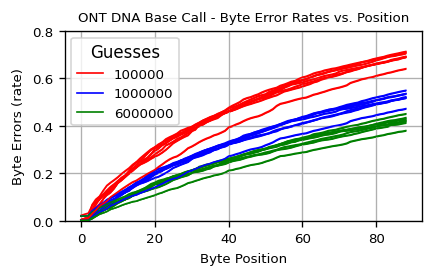

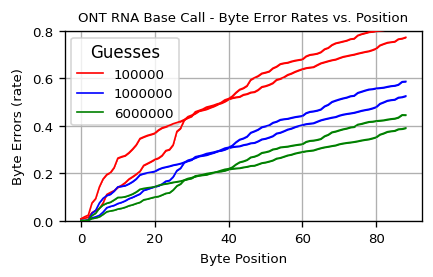

In [4]:
from matplotlib.lines import Line2D

algorithms = [
("Production DNA Basecall",dna_production_basecall,2000),
#("CTC DNA Basecall",dna_ctc_basecall),
("Production RNA Basecall",rna_production_basecall,2000),
#("Rodan RNA Basecall", rna_rodan_basecall,0)
]


def add_strand_entry(d,strandID):
    d[strandID]={}
    d[strandID]["guesses"]=[]
    d[strandID]["error_rates"]=[]
    d[strandID]["total_strands"]=[]
    
BATCH_ALG_AVERAGE_BYTE_ERROR_RATE={b:{} for b in BATCH_NAMES} #make another layer so that we can have the average byte error rates for both algorithm and batch
average_byte_error_rate_guess=[100000,1000000,6000000]
target_batches=["231206_dna_datastorage_1667_batch_full_1667",
                #"231207_dna_datastorage_others_fl_batch_1250_fl",
                #"231207_dna_datastorage_others_fl_batch_5000_fl",
                #"231207_dna_datastorage_others_fl_batch_3333_fl",
                #"231206_dna_datastorage_1667_batch_quarter_1667"
               ]
ID_string="[1-9]+"
#ID_string="(1|2)"
for b in target_batches:
    print("===========Analyzing Batch {} ===================".format(b))
    algorithm_average_byte_error_rate=BATCH_ALG_AVERAGE_BYTE_ERROR_RATE[b]
    for a in algorithms:
        data = a[1]
        edit_df = data[(data.experiment_path.str.match(".*{batch}.*.fastq".format(batch=b)))]
        if edit_df.empty and b==DEFAULT_BATCH_NAME: edit_df = data[(data["encoder::filter_lower_length"]==a[2])]
        if edit_df.empty: continue
        algorithm_average_byte_error_rate[a[0]]={}
        strand_dict={}
        for index,row in edit_df.iterrows():
            try:
                strandID = re.search("strand_?({})_.*".format(ID_string),row["experiment_path"]).group(1)
            except: continue
            if strandID not in strand_dict:add_strand_entry(strand_dict,strandID)
            #Compare Error Rates Across guess limits for run 1
            if row["encoder::hedges_guesses"] in strand_dict[strandID]["guesses"]: continue
            strand_dict[strandID]["guesses"].append(row["encoder::hedges_guesses"])
            strand_dict[strandID]["error_rates"].append(row["payload::hedges::total_errors"])
            strand_dict[strandID]["total_strands"].append(row["payload::hedges::total_strands"])
        plt.figure(figsize=(3.5, 2.2), dpi=120,constrained_layout=True)
        ax=plt.gca()
        colors=["red","blue","green"]#plt.rcParams['axes.prop_cycle'].by_key()['color']
        linestyle=["-","dotted"]
        desired_guesses=[100000,1000000,6000000]
        index_of_guess=[]
        collect_strand_byte_error_rates={_:[] for _ in average_byte_error_rate_guess}
        for strandID in strand_dict:       
            guesses=strand_dict[strandID]["guesses"]
            error_rates=strand_dict[strandID]["error_rates"]
            total_strands=strand_dict[strandID]["total_strands"]
            plot_counter=0
            for index,(g,rates,total) in enumerate(sorted(zip(guesses,error_rates,total_strands),key=lambda x:x[0])):
                if g not in desired_guesses: continue
                if plot_counter==0:
                    label=strandID
                else: label=""
                print("Last Byte Error Rate, GUESSUES:{}  ID: {}  ERROR_RATE: {} MEAN: {}".format(g,strandID,rates[-1]/total,np.mean(np.array(rates)/total)))
                error = 1.96*np.sqrt(((rates/total)*(1-(rates/total))))/np.sqrt(total)
                y=rates/total
                plt.plot(range(len(rates)),y,linewidth=1.0,label=label,color=colors[plot_counter],linestyle="-",zorder=10)
                plt.fill_between(range(len(rates)),y-error,y+error,color=colors[plot_counter],zorder=0,linewidth=0)
                index_of_guess.append(index)
                plot_counter+=1
                if g in average_byte_error_rate_guess:
                    collect_strand_byte_error_rates[g].append(rates/total)
        legend_elements = [Line2D([0], [0], color=c, lw=1, label=str(l)) for c,l in zip(colors,desired_guesses)]
        ax.legend(handles=legend_elements,title="Guesses",fontsize=8)
        
        for g in collect_strand_byte_error_rates:
            byte_rates = collect_strand_byte_error_rates[g]
            algorithm_average_byte_error_rate[a[0]][g]=np.mean([np.mean([_[i] for _ in byte_rates]) for i in list(range(len(byte_rates[0])))[2:]])
        plt.grid()
        plt.ylim([0,0.8])
        title_rename={
            "Production DNA Basecall": "ONT DNA Base Call",
            "Production RNA Basecall": "ONT RNA Base Call"
        }
        plt.xlabel("Byte Position",fontsize=8)
        plt.ylabel("Byte Errors (rate)",fontsize=8)
        ax.xaxis.set_tick_params(labelsize=8)
        ax.yaxis.set_tick_params(labelsize=8)
        try:
            plt.title("{} - Byte Error Rates vs. Position".format(title_rename[a[0]]),fontsize=8)
        except: pass
        plt.savefig("{}_{}_error_rate_vs_pos.png".format(a[0],b),dpi=1200)


## Runtime vs. Byte Error Rate

DNA-ONT
('', '1000000')
1000000 -- Mean 0.3216001117517528 Error 0.000864230894339344
Percent of strands correctly decoded 0.4693199277064675
('', '800000')
800000 -- Mean 0.33181496447713377 Error 0.0008687167543676716
Percent of strands correctly decoded 0.4558859560877323
('', '6000000')
6000000 -- Mean 0.2539309699034786 Error 0.0008202563696804227
Percent of strands correctly decoded 0.5582009056869183
('', '100000')
100000 -- Mean 0.4494389982284123 Error 0.0008846349248598794
Percent of strands correctly decoded 0.30623142577950474
('', '3000000')
3000000 -- Mean 0.27790068793981826 Error 0.0008390702228615872
Percent of strands correctly decoded 0.5272931145310576
('', '400000')
400000 -- Mean 0.36534952437264295 Error 0.0008788505227688092
Percent of strands correctly decoded 0.4114072737440152
[100000, 400000, 800000, 1000000, 3000000, 6000000]
Algorithm DNA-ONT
Compute cost x: (0.2539309699034786, 0.27790068793981826, 0.3216001117517528, 0.33181496447713377, 0.36534952437264

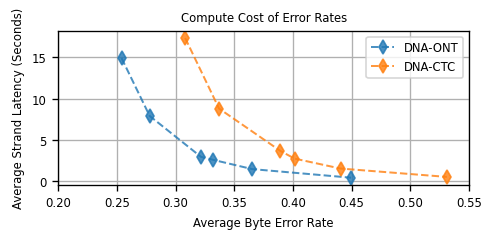

In [12]:
from matplotlib.lines import Line2D

algorithms = [
("DNA-ONT",dna_production_basecall,2000),
#("RNA-ONT",rna_production_basecall,2000),
#("Rodan", rna_rodan_basecall,0),
("DNA-CTC", dna_ctc_basecall,0),
]


def add_strand_entry(d,strandID):
    d[strandID]={}
    d[strandID]["guesses"]=[]
    d[strandID]["error_rates"]=[]
    d[strandID]["total_strands"]=[]
    d[strandID]["average_error_rate"]=[]
    d[strandID]["average_strand_latency"]=[]
    d[strandID]["raw_latency"]=[]
    
target_batches=["231206_dna_datastorage_1667_batch_full_1667"]

strandID_string="([0-9]+)"
#strandID_string="(1|2)"



for b in target_batches: #plot latencies and error rates for each batch individually
    aggregate_latency_fig,ax2 = plt.subplots(figsize=(4, 1.9), dpi=120,constrained_layout=True)    
    for a in algorithms:
        data = a[1]
        print(a[0])
        edit_df = data[data.experiment_path.str.match(".*{batch}.*.fastq".format(batch=b))]
        if edit_df.empty and b==DEFAULT_BATCH_NAME:
            for _ in data["payload::hedges::total_strands"]: print(_)
            edit_df = data[(data["encoder::filter_lower_length"]==a[2])]
        if edit_df.empty: continue
        strand_dict={}
        aggregate_dict={}
        guesses_set=set()
        guesses_error_rates={"Error":{},"Overall Mean": {}}
        for index,row in edit_df.iterrows():guesses_set.add(row["encoder::hedges_guesses"])
        for guess in guesses_set:
            tmp_df = edit_df[(edit_df["encoder::hedges_guesses"]==guess) & (edit_df.experiment_path.str.match(".*strand_?{}(_|\.).*".format(strandID_string)))]
            tmp_entry="{}".format(guess)
            tmp_algorithms=[(tmp_entry,tmp_df)]
            tmp_averages,_=plot_viterbi_rates_vs_length(tmp_algorithms,None,0,0,False,baseline_fail=False)
            guesses_error_rates["Overall Mean"][guess]=tmp_averages[tmp_entry]["Overall Mean"]
            guesses_error_rates["Error"][guess]=tmp_averages[tmp_entry]["Overall Error"]

        
        for index,row in edit_df.iterrows():
            strandID = re.search("strand_?([0-9]+)(_|\.)",row["experiment_path"]).group(1)
            #print(strandID)
            if strandID not in strand_dict:add_strand_entry(strand_dict,strandID)
            #Compare Error Rates Across guess limits for run 1
            if row["encoder::hedges_guesses"] in strand_dict[strandID]["guesses"]: continue
            strand_dict[strandID]["guesses"].append(row["encoder::hedges_guesses"])
            strand_dict[strandID]["total_strands"].append(row["payload::hedges::total_strands"])
            strand_dict[strandID]["average_strand_latency"].append(row["average_strand_compute_time::pessimistic"])
            strand_dict[strandID]["raw_latency"]=strand_dict[strandID]["average_strand_latency"][-1]*row["payload::hedges::total_strands"]

            if row["encoder::hedges_guesses"] not in aggregate_dict:
                g = row["encoder::hedges_guesses"] 
                aggregate_dict[g]={}
                aggregate_dict[g]["total_strands"]=row["payload::hedges::total_strands"]
                aggregate_dict[g]["total_latency"]=row["average_strand_compute_time::pessimistic"]*row["payload::hedges::total_strands"]
            else:
                g = row["encoder::hedges_guesses"] 
                aggregate_dict[g]["total_strands"]+=row["payload::hedges::total_strands"]
                aggregate_dict[g]["total_latency"]+=(row["average_strand_compute_time::pessimistic"]*row["payload::hedges::total_strands"])
        #print(sorted(aggregate_dict.keys()))
        aggregate_rate_latency_pairs=[]
        print(sorted(aggregate_dict.keys()))
        for g in aggregate_dict:
            total_strands = aggregate_dict[g]["total_strands"]
            total_latency = aggregate_dict[g]["total_latency"]
            aggregate_rate_latency_pairs.append((guesses_error_rates["Overall Mean"][g],total_latency/total_strands))

        colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
        linestyle=["-","dotted"]
        index_of_guess=[]
        x,y=zip(*sorted(aggregate_rate_latency_pairs,key=lambda x:x[0]))
        print("Algorithm {}".format(a[0]))
        print("Compute cost x: {}".format(x))
        print("Compute cost y: {}".format(y))
        ax2.plot(x,y,linewidth=1.2,label="{}".format(a[0]),linestyle='--',marker="d",markersize=6,alpha=0.8)
        ax2.set_xlabel("Average Byte Error Rate",fontsize=7)
        ax2.set_ylabel("Average Strand Latency (Seconds)",fontsize=7)
        ax2.set_title("Compute Cost of Error Rates".format(b),fontsize=7)
        ax2.grid(zorder=0)
        ax2.set_xlim([0.2,0.55])
        #ax2.set_yscale("log")
        ax2.legend(fontsize=7)
    ax2.xaxis.set_tick_params(labelsize=7)
    ax2.yaxis.set_tick_params(labelsize=7)
    aggregate_latency_fig.savefig("compute_vs_error_rates.png",dpi=1200)

# Soft Decoder Error Rates

## Byte Error Rate For Viterbi Decoding

('', 'DNA Beam')
('', 'DNA Alignment Matrix')
DNA Beam -- Mean 0.02255747126436781 Error 0.004501490502980312
Percent of strands correctly decoded 0.84075
DNA Alignment Matrix -- Mean 0.03524942528735632 Error 0.002217897700947087
Percent of strands correctly decoded 0.87155


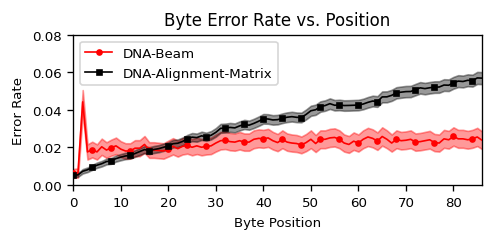

17


In [10]:
from matplotlib.lines import Line2D

dna_main_df = pd.read_pickle("231220_main_dna.pickle")
dna_df_dict=separate_master_data_frame(dna_main_df,None)
#rna/dna soft decoding data
bonito_viterbi_rna = pd.read_pickle("220826_hedges_rodan.pickle")
bonito_viterbi_dna = dna_df_dict["hedges"]
bonito_viterbi_dna=bonito_viterbi_dna[bonito_viterbi_dna["encoder::byte_error_map"]==True]



fig,ax1=plt.subplots(1,1,figsize=(4, 1.9), dpi=120,constrained_layout=True)
algorithms = [
("DNA Beam",bonito_viterbi_dna[bonito_viterbi_dna.experiment_path.str.match(".*full_1667_hedges_beam.*")]),
("DNA Alignment Matrix",bonito_viterbi_dna[bonito_viterbi_dna.experiment_path.str.match(".*full_1667_hedges_strand_?(1|2)_.*")]),
#("RNA Alignment Matrix",bonito_viterbi_rna),
]

style_dictionary={
        "DNA Alignment Matrix":{
                "color":"black",
                "marker":"s",
                "label":"DNA-Alignment-Matrix",
                "ax":ax1
        },
        "RNA Alignment Matrix":{
            "color":"blue",
            "marker":"d",
            "label":"RNA-Alignment-Matrix",
            "ax":ax1,
        },
        "DNA Beam":{
            "color":"red",
            "marker":"o",
            "label":"DNA-Beam",
            "ax":ax1
        }
}

_,BONITO_ALG_AVERAGE_BYTE_ERROR_RATE=plot_viterbi_rates_vs_length(algorithms,style_dictionary,xlim=(0,86),ylim=(0,0.08))
ax1.set_xlabel("Byte Position",fontsize=7)
ax1.set_ylabel("Byte Error Rate",fontsize=7)
ax1.set_title("Byte Error Rate vs. Position",fontsize=7)
ax1.legend(fontsize=7)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
fig.savefig("beam_vs_alignment_matrix.png",dpi=1200)
compare=np.array(_["DNA Beam"]["Total"])>np.array(_["DNA Alignment Matrix"]["Total"])
for i in range(compare.shape[0]):
    if not compare[i]==True:
        print(i)
        break

## Byte Error rate for Viterbi RNA Decoding

('', 'RNA Alignment Matrix')
RNA Alignment Matrix -- Mean 0.12521551724137933 Error 0.003881967774967819
Percent of strands correctly decoded 0.74335


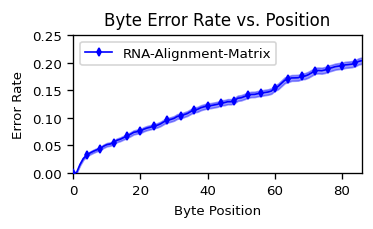

In [7]:
from matplotlib.lines import Line2D

#rna/dna soft decoding data
bonito_viterbi_rna = pd.read_pickle("220826_hedges_rodan.pickle")


fig,ax1=plt.subplots(1,1,figsize=(3, 1.8), dpi=120,constrained_layout=True)
algorithms = [

("RNA Alignment Matrix",bonito_viterbi_rna),
]

style_dictionary={
        "RNA Alignment Matrix":{
            "color":"blue",
            "marker":"d",
            "label":"RNA-Alignment-Matrix",
            "ax":ax1,
        },
}

_,_=plot_viterbi_rates_vs_length(algorithms,style_dictionary,xlim=(0,86),ylim=(0,0.25))
fig.savefig("rna_alignment_matrix.png",dpi=1200)

## Comapring Viterbi on Different Lengths

PRINTING RESULTS FOR QSCORE FILTER
('', 'Alignment Matrix - Full')
('', 'Alignment Matrix - Half')
('', 'Alignment Matrix - Quarter')
Alignment Matrix - Full -- Mean 0.011256486042692937 Error 0.0006926261002564227
Percent of strands correctly decoded 0.9471142857142857
Alignment Matrix - Half -- Mean 0.009307692307692307 Error 0.0012133839071474652
Percent of strands correctly decoded 0.95155
Alignment Matrix - Quarter -- Mean 0.0029233333333333333 Error 0.0006669506335429864
Percent of strands correctly decoded 0.9927


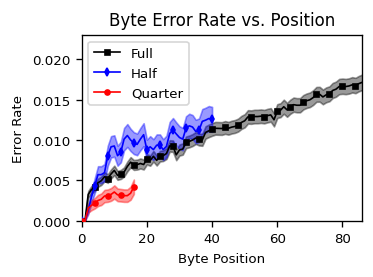

In [15]:
from matplotlib.lines import Line2D
if CANONICAL:
    print("PRINTING RESULTS FOR CANONCICAL")
    dna_main_df = pd.read_pickle("231220_main_dna.pickle")
    dna_df_dict=separate_master_data_frame(dna_main_df,None)
    bonito_viterbi_dna = dna_df_dict["hedges"]

else:
    print("PRINTING RESULTS FOR QSCORE FILTER")
    dna_main_df = pd.read_pickle("qscore_range_experiments_new.pickle")
    dna_df_dict=separate_master_data_frame(dna_main_df,("15.1","15.4"))
    bonito_viterbi_dna = dna_df_dict["hedges"]
    bonito_viterbi_dna=bonito_viterbi_dna[bonito_viterbi_dna["encoder::byte_error_map"]==True]





algorithms = [
("Alignment Matrix - Full",bonito_viterbi_dna[bonito_viterbi_dna.experiment_path.str.match(".*full_1667_(s(1|2)_)?hedges_strand.*")]),
("Alignment Matrix - Half",bonito_viterbi_dna[bonito_viterbi_dna.experiment_path.str.match(".*half_1667_hedges_strand.*")]),
("Alignment Matrix - Quarter",bonito_viterbi_dna[bonito_viterbi_dna.experiment_path.str.match(".*quarter_1667_hedges_strand.*")])
]


fig,ax1=plt.subplots(1,1,figsize=(3,2.2), dpi=120,constrained_layout=True)
style_dictionary={
        "Alignment Matrix - Full":{
                "color":"black",
                "marker":"s",
                "label":"Full",
                "ax":ax1
        },
        "Alignment Matrix - Half":{
            "color":"blue",
            "marker":"d",
            "label":"Half",
            "ax":ax1,
        },
        "Alignment Matrix - Quarter":{
            "color":"red",
            "marker":"o",
            "label":"Quarter",
            "ax":ax1
        }
}
ax1.set_title("Various Strand Length Error Rates",fontsize=8)
_,bonito_variable_length=  plot_viterbi_rates_vs_length(algorithms,style_dictionary,xlim=(0,86),ylim=(0,0.023))
fig.savefig("variable_length_byte_error_rate.png",dpi=1200)


## Comparing Viterbi at Different Rates

PRINTING RESULTS FOR QSCORE FILTER
('', 'Alignment Matrix - 1250')
('', 'Alignment Matrix - 1667')
('', 'Alignment Matrix - 3333')
('', 'Alignment Matrix - 5000')
Alignment Matrix - 1250 -- Mean 0.00924921875 Error 0.0012229872742856134
Percent of strands correctly decoded 0.95835
Alignment Matrix - 1667 -- Mean 0.011256486042692937 Error 0.0006926261002564227
Percent of strands correctly decoded 0.9471142857142857
Alignment Matrix - 3333 -- Mean 0.10173409090909091 Error 0.0034989259804975486
Percent of strands correctly decoded 0.60645
Alignment Matrix - 5000 -- Mean 0.3718313909774436 Error 0.0053410519800598175
Percent of strands correctly decoded 0.10345


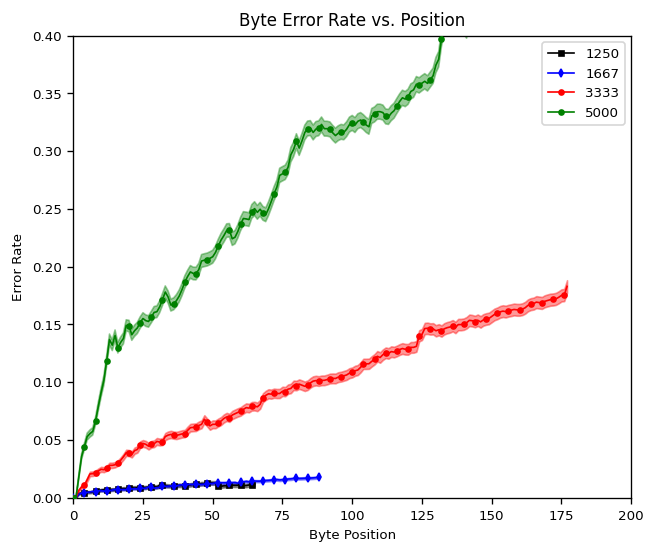

In [13]:
from matplotlib.lines import Line2D

if CANONICAL:
    print("PRINTING RESULTS FOR CANONCICAL")
    dna_main_df = pd.read_pickle("231220_main_dna.pickle")
    dna_df_dict=separate_master_data_frame(dna_main_df,None)
    bonito_viterbi_dna = dna_df_dict["hedges"]
else:
    print("PRINTING RESULTS FOR QSCORE FILTER")
    dna_main_df = pd.read_pickle("qscore_range_experiments_new.pickle")
    dna_df_dict=separate_master_data_frame(dna_main_df,("15.1","15.4"))
    bonito_viterbi_dna = dna_df_dict["hedges"]
    bonito_viterbi_dna=bonito_viterbi_dna[bonito_viterbi_dna["encoder::byte_error_map"]==True]




algorithms = [
("Alignment Matrix - 1250",bonito_viterbi_dna[bonito_viterbi_dna.experiment_path.str.match(".*1250_fl_hedges_strand.*")]),
("Alignment Matrix - 1667",bonito_viterbi_dna[bonito_viterbi_dna.experiment_path.str.match(".*full_1667_(s(1|2)_)?hedges_strand.*")]),
("Alignment Matrix - 3333",bonito_viterbi_dna[bonito_viterbi_dna.experiment_path.str.match(".*333_fl_hedges_strand.*")]),
("Alignment Matrix - 5000",bonito_viterbi_dna[bonito_viterbi_dna.experiment_path.str.match(".*5000_fl_hedges_strand.*")]),
]


fig,ax1=plt.subplots(1,1,figsize=(6, 5), dpi=120)
style_dictionary={
        "Alignment Matrix - 1250":{
                "color":"black",
                "marker":"s",
                "label":"1250",
                "ax":ax1
        },
        "Alignment Matrix - 1667":{
            "color":"blue",
            "marker":"d",
            "label":"1667",
            "ax":ax1,
        },
        "Alignment Matrix - 3333":{
            "color":"red",
            "marker":"o",
            "label":"3333",
            "ax":ax1
        },
        "Alignment Matrix - 5000":{
            "color":"green",
            "marker":"o",
            "label":"5000",
            "ax":ax1
        }
}

bonito_hedges_variable_rates,bonito_hedges_variable_rates_average=plot_viterbi_rates_vs_length(algorithms,style_dictionary,xlim=(0,200),ylim=(0,0.4))


## Hedges Error Rates Different Lengths

('', 'ONT-Full')
('', 'ONT-Quarter')
('', 'ONT-Half')
ONT-Full -- Mean 0.7521515037593985 Error 0.001202354015340684
Percent of strands correctly decoded 0.00393
ONT-Quarter -- Mean 0.10982766666666667 Error 0.0010806389116555415
Percent of strands correctly decoded 0.803145
ONT-Half -- Mean 0.2103105128205128 Error 0.0014239370463218347
Percent of strands correctly decoded 0.63932


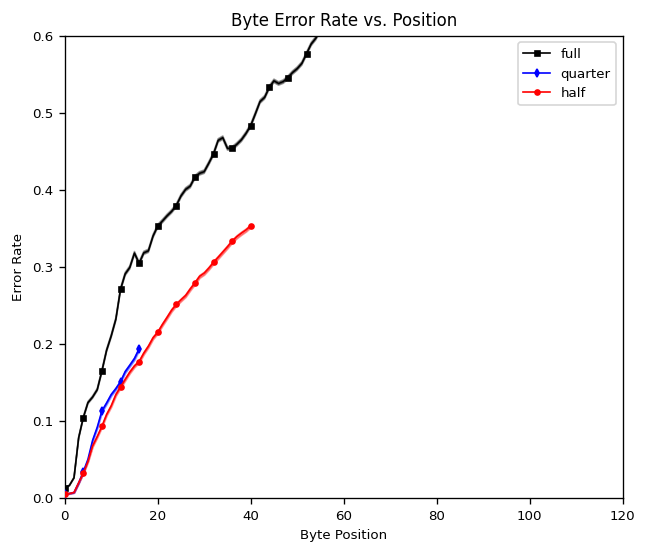

In [10]:
from matplotlib.lines import Line2D

dna_main_df = pd.read_pickle("231220_main_dna.pickle")
dna_df_dict=separate_master_data_frame(dna_main_df,None)
#dna hard decoding
dna_production_basecall = dna_df_dict["ont"]



algorithms = [
("ONT-Full",dna_production_basecall[(dna_production_basecall.experiment_path.str.match(".*5000.*")) &
                                   (dna_production_basecall["encoder::hedges_guesses"]==1000000) ]),
("ONT-Quarter",dna_production_basecall[(dna_production_basecall.experiment_path.str.match(".*_batch_quarter_1667_ont.*")) &
                                      (dna_production_basecall["encoder::hedges_guesses"]==1000000)]),
("ONT-Half",dna_production_basecall[(dna_production_basecall.experiment_path.str.match(".*batch_half_1667_ont.*")) & 
                                      (dna_production_basecall["encoder::hedges_guesses"]==1000000)]),
]

fig,ax1=plt.subplots(1,1,figsize=(6, 5), dpi=120)
style_dictionary={
        "ONT-Full":{
                "color":"black",
                "marker":"s",
                "label":"full",
                "ax":ax1
        },
        "ONT-Quarter":{
            "color":"blue",
            "marker":"d",
            "label":"quarter",
            "ax":ax1,
        },
        "ONT-Half":{
            "color":"red",
            "marker":"o",
            "label":"half",
            "ax":ax1
        }
}

_,_=plot_viterbi_rates_vs_length(algorithms,style_dictionary,xlim=(0,120),ylim=(0,0.6))


## Qscore vs. Average Byte Error Rate

['10.9', '11.2', '11.5', '11.8', '12.1', '12.4', '12.7', '13.0', '13.3', '13.6', '13.9', '14.2', '14.5', '14.8', '15.1', '15.4']
{'0.1667 - Half': {'x': [], 'y': [], 'error': []}, '1667 - Full': {'x': [], 'y': [], 'error': []}, '0.1667 - Quarter': {'x': [], 'y': [], 'error': []}, '0.125': {'x': [], 'y': [], 'error': []}, '0.33': {'x': [], 'y': [], 'error': []}, '0.5': {'x': [], 'y': [], 'error': []}}
('', '0.1667 - Half')
('', '1667 - Full')
('', '0.1667 - Quarter')
('', '0.125')
('', '0.33')
('', '0.5')
0.1667 - Half -- Mean 0.02287948717948718 Error 0.0018180773947097382
Percent of strands correctly decoded 0.90065
1667 - Full -- Mean 0.037471921182266006 Error 0.0011958967013681356
Percent of strands correctly decoded 0.8304285714285714
0.1667 - Quarter -- Mean 0.009286666666666669 Error 0.0011649997165338179
Percent of strands correctly decoded 0.972
0.125 -- Mean 0.02258046875 Error 0.0018231904196964232
Percent of strands correctly decoded 0.90875
0.33 -- Mean 0.2654852272727273 

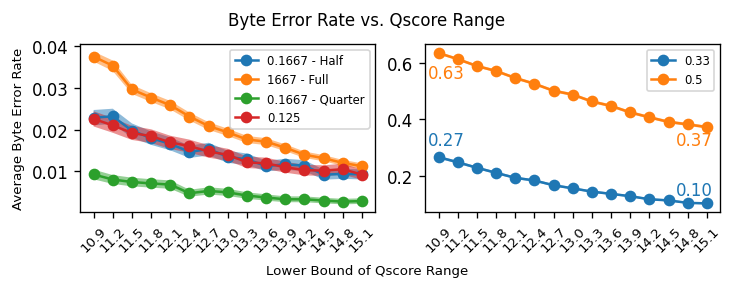

In [11]:
#load data
dna_main_df = pd.read_pickle("qscore_range_experiments_new.pickle")
dna_df_dict=separate_master_data_frame(dna_main_df,None)
#rna/dna soft decoding data
bonito_viterbi_dna = dna_df_dict["hedges"]
bonito_viterbi_dna=bonito_viterbi_dna[bonito_viterbi_dna["encoder::byte_error_map"]==True]


r=(10.9,15.4)
step=0.3
endpoints=np.linspace(r[0],r[1],int(np.round((r[1]-r[0])/step)+1))
endpoints=["{:.1f}".format(_) for _ in endpoints]

print(endpoints)

algorithms = [
("0.1667 - Half",bonito_viterbi_dna[bonito_viterbi_dna.experiment_path.str.match(".*half_1667_hedges_strand.*")]),
("1667 - Full",bonito_viterbi_dna[bonito_viterbi_dna.experiment_path.str.match(".*full_1667_(s(1|2)_)?hedges_strand.*")]),
("0.1667 - Quarter",bonito_viterbi_dna[bonito_viterbi_dna.experiment_path.str.match(".*quarter_1667_hedges_strand.*")]),
("0.125",bonito_viterbi_dna[bonito_viterbi_dna.experiment_path.str.match(".*1250_fl_hedges_strand.*")]),
("0.33",bonito_viterbi_dna[bonito_viterbi_dna.experiment_path.str.match(".*333_fl_hedges_strand.*")]),
("0.5",bonito_viterbi_dna[bonito_viterbi_dna.experiment_path.str.match(".*5000_fl_hedges_strand.*")])
]

plot_dict={
    _[0]:{"x":[],"y":[], "error":[]} for _ in algorithms
}
print(plot_dict)
for i,e in enumerate(endpoints):
    if i==len(endpoints)-1: break
    lower = endpoints[i]
    upper=endpoints[i+1]
    qscore_algorithms=[]
    for a in algorithms:
        #go through each algorithm and compute a new tuple with just the qscore_range desired for each algorithm
        df = a[1]
        qscore_df = df[df.experiment_path.str.match(".*QSCORE_{lower}_{upper}_.*".format(lower=lower,upper=upper))]
        if qscore_df.empty: continue
        qscore_algorithms.append((a[0],qscore_df))
    if len(qscore_algorithms)==0: continue
    #now run byte error calculations on the new set
    _,averages=plot_viterbi_rates_vs_length(qscore_algorithms,None,0,0,False)
    for a in qscore_algorithms:
        plot_dict[a[0]]["y"].append(_[a[0]]["Overall Mean"])
        plot_dict[a[0]]["error"].append(_[a[0]]["Overall Error"])
        plot_dict[a[0]]["x"].append(lower)
        #print("{} {}".format(_[a[0]]["Overall Mean"],_[a[0]]["Overall Error"]))

        
#plot all the average byte error rates
fig,ax1=plt.subplots(1,2,figsize=(6,2.3), dpi=120,constrained_layout=True)
for a in algorithms[0:4]:
    ax1[0].plot(plot_dict[a[0]]["x"],plot_dict[a[0]]["y"],label=a[0],marker="o")
    print(plot_dict[a[0]]["y"])
    ax1[0].fill_between(plot_dict[a[0]]["x"],np.array(plot_dict[a[0]]["y"])-np.array(plot_dict[a[0]]["error"]),
                        np.array(plot_dict[a[0]]["y"])+np.array(plot_dict[a[0]]["error"]),alpha=0.5,zorder=0)

    
ax1[0].legend(fontsize=7)
ax1[0].set_ylabel("Average Byte Error Rate",fontsize=8)
ax1[0].xaxis.set_tick_params(labelsize=8,rotation=45)


design_dict={
    "0.33":{"lowq_text":(0.01,0.4),"highq_text":(0.85,0.1),"color":"tab:blue"},
    "0.5":{"lowq_text":(0.01,0.8),"highq_text":(0.85,0.4),"color":"tab:orange"}
}

for a in algorithms[4::]:
    #print(plot_dict[a[0]]["error"])
    print("===========Algorithm {}==========".format(a[0]))
    print(np.array(plot_dict[a[0]]["y"])[1:]-np.array(plot_dict[a[0]]["y"][:-1]))
    print("=================================".format(a[0]))
    ax1[1].plot(plot_dict[a[0]]["x"],plot_dict[a[0]]["y"],label=a[0],marker="o")  
    ax1[1].fill_between(plot_dict[a[0]]["x"],np.array(plot_dict[a[0]]["y"])-np.array(plot_dict[a[0]]["error"]),
                        np.array(plot_dict[a[0]]["y"])+np.array(plot_dict[a[0]]["error"]),alpha=0.5,zorder=0)
    #print(plot_dict[a[0]]["y"])
    low_coord=design_dict[a[0]]["lowq_text"]
    upper_coord=design_dict[a[0]]["highq_text"]
    color=design_dict[a[0]]["color"]
    ax1[1].text(*low_coord,"{:.2f}".format(plot_dict[a[0]]["y"][0]),transform=ax1[1].transAxes,color=color)
    ax1[1].text(*upper_coord,"{:.2f}".format(plot_dict[a[0]]["y"][-1]),transform=ax1[1].transAxes,color=color)

ax1[1].legend(fontsize=7)
ax1[1].xaxis.set_tick_params(labelsize=8,rotation=45)
plt.suptitle("Byte Error Rate vs. Qscore Range",fontsize=10)
fig.supxlabel('Lower Bound of Qscore Range',fontsize=8)
fig.savefig("qscore_sweep.png",dpi=1200)



## 1667 Length and Qscore Analysis

15.1,15.4
('', '0.167-Half')
0.167-Half 2 [0.0008 0.0024 0.0039 0.0043 0.0046 0.0048]
0.167-Half 1 [0.0018 0.0035 0.0048 0.0071 0.0068 0.0071]
('', '0.167-Quarter')
0.167-Quarter 4 [0.0011 0.0014 0.0016 0.002  0.002  0.0026]
0.167-Quarter 3 [0.002  0.0024 0.0027 0.003  0.0033 0.0035]
('', '0.167-Full')
0.167-Full 18 [0.0053 0.0059 0.0059 0.0065 0.0066 0.0071]
0.167-Full 16 [0.0038 0.0044 0.0041 0.0053 0.0052 0.0063]
0.167-Full 17 [0.0037 0.0041 0.0049 0.0051 0.0051 0.0059]
0.167-Full 2 [0.0031 0.0038 0.0043 0.005  0.0049 0.005 ]
0.167-Full 15 [0.0016 0.0023 0.0025 0.0034 0.0043 0.004 ]
0.167-Full 14 [0.0016 0.0022 0.0023 0.0023 0.0028 0.0036]
0.167-Full 1 [0.0037 0.0042 0.005  0.0053 0.0057 0.0062]
0.167-Half -- Mean 0.009307692307692307 Error 0.0012133839071474652
Percent of strands correctly decoded 0.95155
0.167-Quarter -- Mean 0.0029233333333333333 Error 0.0006669506335429864
Percent of strands correctly decoded 0.9927
0.167-Full -- Mean 0.011256486042692937 Error 0.000692626100256

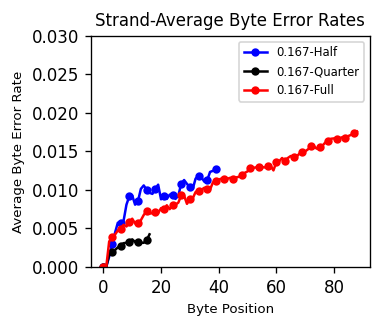

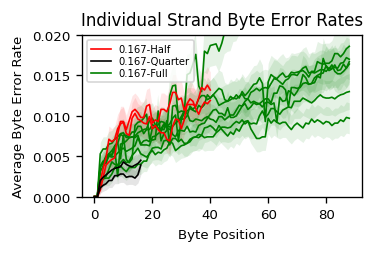

In [12]:
#plot the different length experiments for different qscores

dna_main_df = pd.read_pickle("qscore_range_experiments_new.pickle")
dna_df_dict=separate_master_data_frame(dna_main_df,None)
#rna/dna soft decoding data
bonito_viterbi_dna = dna_df_dict["hedges"]
bonito_viterbi_dna=bonito_viterbi_dna[bonito_viterbi_dna["encoder::byte_error_map"]==True]


#endpoints=[("14.2","14.5"),("14.5","14.8")]
r=(10.9,15.4)
step=0.3
endpoints=np.linspace(r[0],r[1],int(np.round((r[1]-r[0])/step)+1))
endpoints_l=["{:.1f}".format(_) for _ in endpoints[:-1]]
endpoints_r=["{:.1f}".format(_) for _ in endpoints[1:]]
endpoints=[list(zip(endpoints_l,endpoints_r))[-1]]



algorithms = [
("0.167-Half",bonito_viterbi_dna[bonito_viterbi_dna.experiment_path.str.match(".*half_1667_hedges_strand.*")]),
("0.167-Quarter",bonito_viterbi_dna[bonito_viterbi_dna.experiment_path.str.match(".*quarter_1667_hedges_strand.*")]),
("0.167-Full",bonito_viterbi_dna[(bonito_viterbi_dna.experiment_path.str.match(".*full_1667_(s(1|2)_)?hedges_strand.*")) & (bonito_viterbi_dna["encoder::byte_error_map"]==True)]),
#("5000",bonito_viterbi_dna[bonito_viterbi_dna.experiment_path.str.match(".*5000_fl_hedges_strand.*")]),
#("5000",bonito_viterbi_dna[bonito_viterbi_dna.experiment_path.str.match(".*3333_fl_hedges_strand.*")])
]


plot_dict={
    _[0]:{"x":[],"y":[]} for _ in algorithms
}

marker_list=["o","*","D"]
color_list=["blue","black","red"]
fig,ax1=plt.subplots(1,1,figsize=(3,2.5), dpi=120)
for index,(lower,upper) in enumerate(endpoints):
    print("{},{}".format(lower,upper))
    qscore_algorithms=[]
    for a in algorithms:
        #go through each algorithm and compute a new tuple with just the qscore_range desired for each algorithm
        df = a[1]
        qscore_df = df[df.experiment_path.str.match(".*QSCORE_{lower}_{upper}_.*".format(lower=lower,upper=upper))]
        if qscore_df.empty: continue
        qscore_algorithms.append((a[0],qscore_df))
    if len(qscore_algorithms)==0: continue
    strand_aggregate,averages=plot_viterbi_rates_vs_length(qscore_algorithms,None,0,0,True,save_name="individual_strands_length.png")
    for a_index,a in enumerate(qscore_algorithms):
        ax1.plot(range(len(strand_aggregate[a[0]]["Total"])),strand_aggregate[a[0]]["Total"],marker=marker_list[0],
                 color=color_list[a_index],markevery=3,markersize=4,label=a[0])
ax1.set_ylim([0,0.03])
ax1.set_ylabel("Average Byte Error Rate",fontsize=8)
ax1.set_xlabel("Byte Position",fontsize=8)
ax1.set_title("Strand-Average Byte Error Rates",fontsize=10)
ax1.legend(fontsize=7)


# Density vs. Length Projections

## Basic Strand length vs Density Graph

In [16]:

##Pick the batch we want to actually calculate over, we could loop this if we want, but that may be kind of lengthy
def reflect_rates(rates):
    midpoint=len(rates)//2
    new_rates=list(rates[0:midpoint])+list(rates[0:midpoint])[::-1]
    return new_rates[0:len(rates)]

rates = {
    0.1250: {"name":"Alignment Matrix - 1250","l":[2144],},
    0.1667: {"name":"Alignment Matrix - 1667","l":[2160]},
    #0.16666667: {"name":"Alignment Matrix - Half","l":[1008]},
    #0.166666667:{"name":"Alignment Matrix - Quarter","l":[432]},
    0.3333: {"name":"Alignment Matrix - 3333","l":[2148]},
    0.5:    {"name":"Alignment Matrix - 5000","l":[2151]}
}

lengths=list(range(50,2160,50))

system_size=10**12
NON_DATA_BASES = 137 #total number of buffer bases
additional_lengths=[x for r in rates for x in rates[r]["l"]]
additional_lengths=list(np.array(additional_lengths)+NON_DATA_BASES)

    
print(additional_lengths)
lengths=sorted(lengths+additional_lengths)
for r_index,r in enumerate(rates):
    max_length=max(np.array(rates[r]["l"])+NON_DATA_BASES)
    rates[r]["lengths"]=[_ for _ in lengths if _<=max_length]

bonito_rates_average={**bonito_hedges_variable_rates_average,**bonito_variable_length}
#bonito_rates_average={**bonito_hedges_variable_rates_average}
index_bytes=4
for r in rates:
    alg_name=rates[r]["name"]
    densities=[]
    final_lengths=[]
    final_bytes=[-1]
    rate_lengths=rates[r]["lengths"]
    for l in rate_lengths:
        RATE_FACTOR = 1
        SHANNON=2
        RATE=r*RATE_FACTOR
        index_bases= math.ceil(4*8/(2*r))
        if index_bases+NON_DATA_BASES>l: continue
        
        data_bases = (l-(index_bases+NON_DATA_BASES))
        data_bytes=int((data_bases*r)*2//8)
        if data_bytes==0: continue
        final_bytes.append(data_bytes)
        final_lengths.append(l)
        #print(l) 
        
        DATA_FACTOR = data_bytes/(index_bytes+data_bytes)
        BASE_FACTOR = (data_bases+index_bases)/(data_bases+index_bases+NON_DATA_BASES)
        error_rate=np.mean(bonito_rates_average[alg_name][0:data_bytes+index_bytes])
        #print(error_rate)
        ecc,file_success_rate = sweep_file_success_probability(data_bytes,error_rate,system_size)                                                         
        lowest_ecc = find_lowest_ecc(ecc,file_success_rate,10**6)
        final_density = (255-lowest_ecc)*r*SHANNON*BASE_FACTOR*DATA_FACTOR/255
        densities.append(final_density)
    rates[r]["x"]=final_lengths
    rates[r]["y"]=densities
    for l in rates[r]["l"]:
        try:
            pos = rates[r]["x"].index(l+NON_DATA_BASES)
            print("{} Nominal Density - Length {} bp {}:{}".format(alg_name,l,r,rates[r]["y"][pos]))
            print("Error rate used {}".format(error_rate))                  

        except:
            print("{} Density {} for length {} does not exist".format(alg_name,r,l))
 

[2281, 2297, 2285, 2288]
Alignment Matrix - 1250 Nominal Density - Length 2144 bp 0.125:0.18109704206101557
Error rate used 0.00924921875
Alignment Matrix - 1667 Nominal Density - Length 2160 bp 0.1667:0.24083964250044812
Error rate used 0.011256486042692937
Alignment Matrix - 3333 Nominal Density - Length 2148 bp 0.3333:0.2618357514119064
Error rate used 0.10173409090909091
Alignment Matrix - 5000 Nominal Density - Length 2151 bp 0.5:0.0
Error rate used 0.3718313909774436


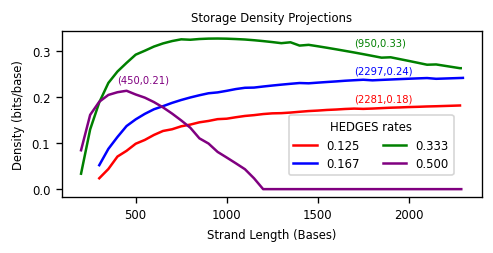

In [32]:
fig,ax1=plt.subplots(1,1,figsize=(4, 2.), dpi=120,constrained_layout=True)
colors=["r","b","g","purple"]

"""
rate_format = {
    0.1250: {"color":"r","pos":(1700,0.15)},
    0.1667: {"color":"b","pos":(1700,0.23)},
    0.3333: {"color":"g","pos":(750,0.23)},
    0.5:    {"color":"purple","pos":(1000,0.01)}
}
"""
rate_format = {
    0.1250: {"color":"r","pos":(1700,0.19)},
    0.1667: {"color":"b","pos":(1700,0.25)},
    0.3333: {"color":"g","pos":(1700,0.31)},
    0.5:    {"color":"purple","pos":(400,0.23)}
}

for r_index,r in enumerate(rates):
    arg_max=np.argmax(rates[r]["y"])
    max_y=rates[r]["y"][arg_max]
    max_x=rates[r]["x"][arg_max]
    ax1.plot(rates[r]["x"],rates[r]["y"],label="{:.3f}".format(r),color=colors[r_index])
    ax1.text(rate_format[r]["pos"][0],rate_format[r]["pos"][1],"({},{:.2f})".format(max_x,max_y),color=colors[r_index],fontsize=6)
legend=ax1.legend(title="HEDGES rates",fontsize=7,ncol=2,loc=(0.54,0.13))
legend.get_title().set_fontsize('7')
ax1.set_xlabel("Strand Length (Bases)",fontsize=7)
ax1.set_ylabel("Density (bits/base)",fontsize=7)
ax1.set_title("Storage Density Projections",fontsize=7)

ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)

fig.savefig("storage_denstiy_projection.png",dpi=1200)


## Length-Time Analysis

### Complete Time (includes Decoder+CTC Generation Model)

{'full': ['2:00:02', '1:57:16', '2:02:11', '2:04:03', '1:58:45', '2:01:38', '2:00:33'], 'half': ['0:34:43', '0:35:10'], 'quarter': ['0:11:54', '0:12:04'], '5000': ['2:14:12', '2:17:51'], '3333': ['2:06:28', '2:07:09'], '1250': ['1:47:26', '1:47:51']}
full time 0.7238285714285714
half time 0.20965
quarter time 0.0719
5000 time 0.81615
3333 time 0.76085
1250 time 0.64585
[1.19899456e-07 3.36416380e-05 1.39391402e-02]


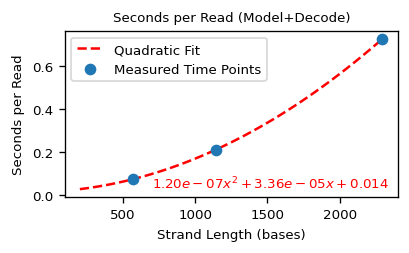

In [15]:
import matplotlib.ticker as mticker

BASE_SCALE=1
names=["full","half","quarter","5000","3333","1250"]
time_dict={
    "full":["2:00:02","1:57:16","2:02:11","2:04:03","1:58:45","2:01:38","2:00:33"],
    "half":["0:34:43","0:35:10"],
    "quarter":["0:11:54","0:12:04"],
    "5000":["2:14:12","2:17:51"],
    "3333":["2:06:28","2:07:09"],
    "1250":["1:47:26","1:47:51"]
}

time_dict={}
with open("ctc_gen_plus_decoder_times.csv","r") as decode_times:
    for line in decode_times:
        times = line.strip().split(",")
        time_dict[times[0].replace('\"',"")]=[str(_.replace('\"',"")) for _ in times[1:]]
print(time_dict)
        
#fig,ax1=plt.subplots(1,1,figsize=(4, 3), dpi=120)
#l=[2160/2160,1008/2160,432/2160]
#l_raw=[2160,1008,432]

l=[2297/2297,1145/2297,569/2297]
l_raw=[2297,1145,569]

total_times=[]
for t_index,t in enumerate(time_dict):
    seconds = sum([int(_.split(":")[0])*3600+int(_.split(":")[1])*60+int(_.split(":")[2]) for _ in time_dict[t]])/(10000*len(time_dict[t]))
    print("{} time {}".format(t,seconds))
    if re.search("(full|half|quarter)",t) is None: continue
    #ax1.scatter([t_index],[seconds],label=t)
    total_times.append(seconds)
#ax1.legend()
#ax1.set_ylabel("Seconds Per Strand")

p,residuals,_,_,_ = np.polyfit(l_raw,np.array(total_times)*BASE_SCALE,2,full=True)
#p,residuals,_,_,_ = np.polyfit(l_raw,np.array(total_times),1,full=True)
print(p)
p_x = np.linspace(200,2300,50)
p_y = [p[0]*pow(_,2)+p[1]*pow(_,1)+p[2] for _ in p_x]
fig,ax1=plt.subplots(1,1,figsize=(3.3, 2), dpi=120,constrained_layout=True)
ax1.plot(p_x,p_y,color="red",linestyle="dashed",label="Quadratic Fit")
ax1.scatter(l_raw,(np.array(total_times)*BASE_SCALE),zorder=10,label="Measured Time Points")
#ax1.scatter(l_raw,np.array(total_times),zorder=10,label="Measured Time Points")
s=r'${:.2e}x^2+{:.2e}x+{:.3f}$'.format(p[0],p[1],p[2])
#print(p[0])
ax1.text(700,.03,s,color="red",fontsize=8)
ax1.set_ylabel("Seconds per Read",fontsize=8)
ax1.set_xlabel("Strand Length (bases)",fontsize=8)
ax1.set_title("Seconds per Read (Model+Decode)",fontsize=8)
ax1.legend(fontsize=8)
ax1.xaxis.set_tick_params(labelsize=8)
ax1.yaxis.set_tick_params(labelsize=8)

fig.savefig("benchmarking_strand_lengths_total.png",dpi=1200)

### Complete Time (CTC Generation Model)

{'full': [' 00:07:48', '00:07:47', '00:07:58', '00:08:08', '00:08:12', '00:07:53'], 'half': [' 00:04:12', '00:04:15'], 'quarter': ['00:02:26', '00:02:31'], '5000': ['00:08:12', '00:08:02'], '3333': ['00:08:29', '00:08:23'], '1250': ['00:05:27', '00:08:23']}
full time 0.047766666666666666
half time 0.02535
quarter time 0.01485
5000 time 0.0487
3333 time 0.0506
1250 time 0.0415
[1.91075562e-05 3.77541956e-03]


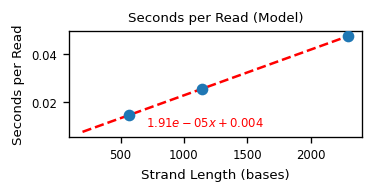

In [16]:
names=["full","half","quarter","5000","3333","1250"]

time_dict={}
with open("ctc_generation_times.csv","r") as decode_times:
    for line in decode_times:
        times = line.strip().split(",")
        time_dict[times[0].replace('\"',"")]=[str(_.replace('\"',"")) for _ in times[1:]]
print(time_dict)
        
#l=[2160/2160,1008/2160,432/2160]
#l_raw=[2160,1008,432]
l=[2297/2297,1145/2297,569/2297]
l_raw=[2297,1145,569]


ctc_gen_times=[]
for t_index,t in enumerate(time_dict):
    seconds = sum([int(_.split(":")[0])*3600+int(_.split(":")[1])*60+int(_.split(":")[2]) for _ in time_dict[t]])/(10000*len(time_dict[t]))
    print("{} time {}".format(t,seconds))
    if re.search("(full|half|quarter)",t) is None: continue
    ctc_gen_times.append(seconds)

#p,residuals,_,_,_ = np.polyfit(l_raw,1/(np.array(ctc_gen_times)/np.array(l_raw)),2,full=True)
p,residuals,_,_,_ = np.polyfit(l_raw,np.array(ctc_gen_times),1,full=True)
print(p)
p_x = np.linspace(200,2300,50)
p_y = [p[0]*pow(_,1)+p[1] for _ in p_x]
fig,ax1=plt.subplots(1,1,figsize=(3, 1.5), dpi=120,constrained_layout=True)
ax1.plot(p_x,p_y,color="red",linestyle="dashed",label="Linear Fit")
#ax1.scatter(l_raw,1/(np.array(ctc_gen_times)/np.array(l_raw)),zorder=10,label="Measured Time Points")
ax1.scatter(l_raw,np.array(ctc_gen_times),zorder=10,label="Measured Time Points")
#print(p[0])
ax1.set_ylabel("Seconds per Read",fontsize=8)
ax1.set_xlabel("Strand Length (bases)",fontsize=8)
ax1.set_title("Seconds per Read (Model)",fontsize=8)
#ax1.legend(fontsize=8,loc="upper left")
s=r'${:.2e}x+{:.3f}$'.format(p[0],p[1])
ax1.text(700,.01,s,color="red",fontsize=7)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
fig.savefig("benchmarking_strand_lengths_ctc_gen.png",dpi=1200)

[0.6760619 0.1843    0.05705  ]
[1.19187798e-07 1.66322535e-05 8.99788716e-03]


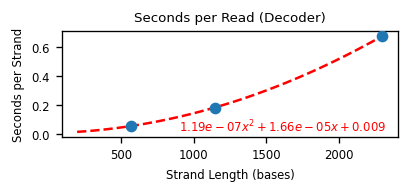

In [17]:
names=["full","half","quarter","5000","3333","1250"]

        
#l=[2160/2160,1008/2160,432/2160]
#l_raw=[2160,1008,432]

l=[2297/2297,1145/2297,569/2297]
l_raw=[2297,1145,569]

decode_times =np.array(total_times)-np.array(ctc_gen_times)
print(decode_times)

p,residuals,_,_,_ = np.polyfit(l_raw,np.array(decode_times),2,full=True)
print(p)
p_x = np.linspace(200,2300,50)
p_y = [p[0]*pow(_,2)+p[1]*pow(_,1)+p[2] for _ in p_x]
fig,ax1=plt.subplots(1,1,figsize=(3.3, 1.5), dpi=120,constrained_layout=True)
ax1.plot(p_x,p_y,color="red",linestyle="dashed",label="Quadratic Fit")
ax1.scatter(l_raw,np.array(decode_times),zorder=10,label="Measured Time Points")
#ax1.scatter(l_raw,np.array(decode_times),zorder=10,label="Measured Time Points")
s=r'${:.2e}x^2+{:.2e}x+{:.3f}$'.format(p[0],p[1],p[2])
#print(p[0])
ax1.text(900,0.02,s,color="red",fontsize=7)
ax1.set_ylabel("Seconds per Strand",fontsize=7)
ax1.set_xlabel("Strand Length (bases)",fontsize=7)
ax1.set_title("Seconds per Read (Decoder)",fontsize=8)
#ax1.legend(fontsize=8)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
fig.savefig("benchmarking_strand_lengths_decoder.png",dpi=1200)

# HEDGES vs. Alignment Matrix Density

## System Size Cost Matrix

In [18]:
from matplotlib.lines import Line2D
dna_main_df = pd.read_pickle("231220_main_dna.pickle")
dna_df_dict=separate_master_data_frame(dna_main_df,None)
bonito_viterbi_dna = dna_df_dict["hedges"]
bonito_viterbi_rna = pd.read_pickle("220826_hedges_rodan.pickle")
bonito_viterbi_dna=bonito_viterbi_dna[bonito_viterbi_dna["encoder::byte_error_map"]==True]

#strand_ID="(1|2)"
strand_ID="([0-9]+)"

algorithms = [
("DNA Alignment Matrix",bonito_viterbi_dna[bonito_viterbi_dna.experiment_path.str.match(".*full_1667_(s(1|2)_)?hedges_strand_?{}(_|\.).*".format(strand_ID))]),
("RNA Alignment Matrix",bonito_viterbi_rna),
("DNA Beam",bonito_viterbi_dna[bonito_viterbi_dna.experiment_path.str.match(".*full_1667_hedges_beam.*")])
]

style_dictionary={
        "DNA Alignment Matrix":{
                "color":"black",
                "marker":"s",
                "label":"DNA-Alignment-Matrix",
                "ax":None
        },
        "RNA Alignment Matrix":{
            "color":"blue",
            "marker":"d",
            "label":"RNA-Alignment-Matrix",
            "ax":None
        },
        "DNA Beam":{
            "color":"red",
            "marker":"o",
            "label":"DNA-Beam",
            "ax":None
        }
}

for i in algorithms[0][1].experiment_path:
    print(i)

bonito_variable_length,BONITO_ALG_AVERAGE_BYTE_ERROR_RATE=  plot_viterbi_rates_vs_length(algorithms,None,xlim=None,ylim=None)


/gpfs_backup/tuck_data/kvolkel/dnastorage/tools/lsf/231221_Paul_merged_experiments/231206_dna_datastorage_1667_batch_full_1667_hedges_strand14_10000.fastq/decoder___0e653077bd9f7a5d8ef8e44967784688
/gpfs_backup/tuck_data/kvolkel/dnastorage/tools/lsf/231221_Paul_merged_experiments/231206_dna_datastorage_1667_batch_full_1667_hedges_strand1_10000.fastq/decoder___fb0cd6ff53a405a24d5f55922029a6c8
/gpfs_backup/tuck_data/kvolkel/dnastorage/tools/lsf/231221_Paul_merged_experiments/231206_dna_datastorage_1667_batch_full_1667_hedges_strand15_10000.fastq/decoder___0e653077bd9f7a5d8ef8e44967784688
/gpfs_backup/tuck_data/kvolkel/dnastorage/tools/lsf/231221_Paul_merged_experiments/231206_dna_datastorage_1667_batch_full_1667_hedges_strand17_10000.fastq/decoder___0e653077bd9f7a5d8ef8e44967784688
/gpfs_backup/tuck_data/kvolkel/dnastorage/tools/lsf/231221_Paul_merged_experiments/231206_dna_datastorage_1667_batch_full_1667_hedges_strand18_10000.fastq/decoder___0e653077bd9f7a5d8ef8e44967784688
/gpfs_backu

0.8952698739799788


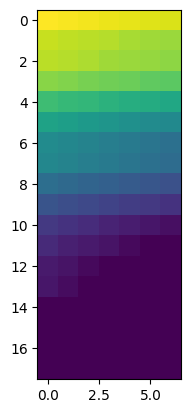

In [19]:
#Pick the batch we want to actually calculate over, we could loop this if we want, but that may be kind of lengthy
algorithm_average_byte_error_rate = BATCH_ALG_AVERAGE_BYTE_ERROR_RATE["231206_dna_datastorage_1667_batch_full_1667"]
bonito_error_rates=BONITO_ALG_AVERAGE_BYTE_ERROR_RATE

algorithm_keys = [
"Production DNA Basecall",
"Production RNA Basecall",
]

specific_error_rate_points = {
    "Tree-DNA-1M":(algorithm_average_byte_error_rate[algorithm_keys[0]][1000000],"o","black","yellow",60),
    "Tree-RNA-1M":(algorithm_average_byte_error_rate[algorithm_keys[1]][1000000],"v","black",None,60),
    "Tree-DNA-6M":(algorithm_average_byte_error_rate[algorithm_keys[0]][6000000],"o","red","yellow",60),
    "Tree-RNA-6M":(algorithm_average_byte_error_rate[algorithm_keys[1]][6000000],"v","red",None,60),
    "Tree-DNA-0.1M":(algorithm_average_byte_error_rate[algorithm_keys[0]][100000],"o","green","yellow",60),
    "DNA-Alignment":(np.mean(bonito_error_rates["DNA Alignment Matrix"]),"v","orange",None,10),
    "RNA-Alignment":(np.mean(bonito_error_rates["RNA Alignment Matrix"]),"v","green",None,10),
    "DNA-Beam":(np.mean(bonito_error_rates["DNA Beam"]),"v","green",None,10)
}



error_rate_points={_:(_,) for _ in np.arange(0.01,0.3,0.03)}
for _ in specific_error_rate_points:
    error_rate_points[_]=(specific_error_rate_points[_][0],)
    #print(_)
    #print(error_rate_points[_])


system_sizes=[10**i for i in range(9,16)]

RATE_FACTOR = 1
SHANNON=2
RATE=0.1667*RATE_FACTOR
NON_DATA_BASES = 137 #total number of buffer bases
NON_DATA_BYTES= 4
DATA_BYTES=83

DATA_FACTOR = DATA_BYTES/(NON_DATA_BYTES+DATA_BYTES)
BASE_FACTOR = ((DATA_BYTES+NON_DATA_BYTES)*8/(RATE*SHANNON))/(((DATA_BYTES+NON_DATA_BYTES)*8/(RATE*SHANNON))+NON_DATA_BASES)

density_matrix = np.zeros((len(error_rate_points),len(system_sizes)))

print(DATA_FACTOR*BASE_FACTOR)

for system_index,(system_size) in enumerate(system_sizes):
    for p_index,(p,_) in enumerate(sorted(error_rate_points.items(),key=lambda x: x[1])):
        name=p
        error_rate=error_rate_points[name][0]
        #print(error_rate)
        ecc,file_success_rate = sweep_file_success_probability(DATA_BYTES*RATE_FACTOR,error_rate,system_size,corruption=True)  
        #print(ecc,file_success_rate)
        lowest_ecc = find_lowest_ecc(ecc,file_success_rate,10**6)
        final_density = (255-lowest_ecc)*RATE*SHANNON*BASE_FACTOR*DATA_FACTOR/255
        density_matrix[p_index,system_index]=final_density
        #plt.scatter([error_rate],[final_density],label=name,color=color,marker=marker,zorder=zorder,s=size,alpha=1,facecolors=facecolors,linewidths=1.0)
plt.imshow(density_matrix)


[0.14397414 0.13929206 0.13460997 0.12992788 0.1252458  0.12056371
 0.11822267]
Label DNA-Alignment error rate (0.025994909688013136,) row 0.2142054298244755
Label RNA-Alignment error rate (0.12521551724137933,) row 0.10651745417501242
Label Tree-RNA-6M error rate (0.2360752298850574,) row 0.012875736218957545
Label Tree-DNA-6M error rate (0.2539309699034786,) row nan
Label Tree-DNA-1M error rate (0.3216001117517528,) row nan
Label Tree-RNA-1M error rate (0.3262008620689655,) row nan
(0.01, (0.01,))
('DNA-Beam', (0.02255747126436781,))
('DNA-Alignment', (0.025994909688013136,))
(0.04, (0.04,))
(0.06999999999999999, (0.06999999999999999,))
(0.09999999999999999, (0.09999999999999999,))
('RNA-Alignment', (0.12521551724137933,))
(0.13, (0.13,))
(0.16, (0.16,))
(0.19, (0.19,))
(0.22, (0.22,))
('Tree-RNA-6M', (0.2360752298850574,))
(0.25, (0.25,))
('Tree-DNA-6M', (0.2539309699034786,))
(0.28, (0.28,))
('Tree-DNA-1M', (0.3216001117517528,))
('Tree-RNA-1M', (0.3262008620689655,))
('Tree-DNA-0.

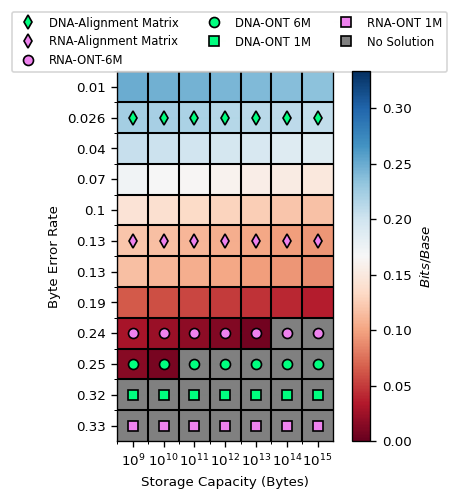

In [30]:
print(density_matrix[5,:])
plt.figure(figsize=(4, 4), dpi=120)
markersize=6
prune_rates=[0.22,0.25,0.28,0.16]#,0.13,0.04,0.1]
prune_rates+=['Tree-DNA-0.1M',"DNA-Beam"]
#prune_rates=[]
prune_indexes=[]
for p in prune_rates:
    for index,_ in enumerate(sorted(error_rate_points.items(),key=lambda x: x[1])):
        if p==_[0]:
            prune_indexes.append(index)
            continue
        if type(p) is str or type(_[0]) is str: continue
        if math.isclose(p,_[0]):
            prune_indexes.append(index)

keep_indexes = [_ for _ in list(range(density_matrix.shape[0])) if _ not in prune_indexes]
sorted_rates = sorted(error_rate_points.items(),key=lambda x: x[1])
labels = []
raw_labels=[]
for index,s in enumerate(sorted_rates):
    if index in keep_indexes:
        if not type(s[0]) is str: 
            labels.append("{:0.2}".format(s[0]))
            raw_labels.append("{:0.2}".format(s[0]))

        else:
            labels.append("{:0.2}".format(s[1][0]))            
            raw_labels.append("{}".format(s[0]))


ax=plt.gca()
plt_density_matrix=density_matrix[keep_indexes,:]
plt_density_matrix=np.where(plt_density_matrix==0,np.nan,plt_density_matrix)

cmap = matplotlib.cm.RdBu.copy()
cmap.set_bad('gray',1.)

for l_i,l in enumerate(raw_labels):
    if not ("DNA" in l or "RNA" in l):continue
    print("Label {} error rate {} row {}".format(l,error_rate_points[l],plt_density_matrix[l_i,3]))

plt.imshow(plt_density_matrix,cmap=cmap, vmin=0, vmax=0.333)
ax.set_xticks([0+_ for _ in range(plt_density_matrix.shape[1])])
ax.set_xticks([-0.5+_ for _ in range(plt_density_matrix.shape[1])],minor=True)
ax.set_yticks([0+_ for _ in range(plt_density_matrix.shape[0])])
ax.set_yticks([-0.5+_ for _ in range(plt_density_matrix.shape[0])],minor=True)
ax.set_yticklabels(labels,fontsize=8)
ax.set_xticklabels(["$10^{%i}$" % int(np.log10(_)) for _ in system_sizes],fontsize=8)
ax.grid(which='minor', color='black', linestyle='-', linewidth=1.24)
ax.set_ylabel("Byte Error Rate",fontsize=8)
ax.set_xlabel("Storage Capacity (Bytes)",fontsize=8)
cbar=plt.colorbar()
cbar.ax.set_ylabel('$Bits/Base$', rotation=-270,fontsize=8)
cbar.ax.tick_params(labelsize=8)



axhline_format_dict = {
    "Tree-DNA-6M":{
        "color":"springgreen",
        "marker":"o"
    },
    "Tree-RNA-6M":{
        "color":"violet",
        "marker":"o"
    },
    "Tree-RNA-1M":{
        "color":"violet",
        "marker":"s"
    },
    "Tree-DNA-1M":{
        "color":"springgreen",
        "marker":"s"
    },
    "DNA-Alignment":{
        "color":"springgreen",
        "marker":"d"
    },
    "RNA-Alignment":{
        "color":"violet",
        "marker":"d"
    }
}



for index, name in enumerate(raw_labels):
    x=[0+_ for _ in range(plt_density_matrix.shape[1])]
    y=[index]*len(x)
    if "DNA" in name or "RNA" in name:
        if "-" in axhline_format_dict[name]["color"]:
            c1,c2 = axhline_format_dict[name]["color"].split("-")
            ax.plot(x,y, c=c1,
                       marker=axhline_format_dict[name]["marker"],
                       markersize=markersize,
                       markerfacecoloralt=c2,
                       fillstyle="right",
                       label=name,linewidth=0.01,markeredgecolor="black")
       
        else:
            ax.plot(x,y,color=axhline_format_dict[name]["color"],marker=axhline_format_dict[name]["marker"]
                   ,linestyle="--",linewidth=0.01,alpha=1,label=name,markeredgecolor="black",markersize=markersize)
legend = ax.legend(bbox_to_anchor=(0.5, 1.08),ncol=2,loc="center",fontsize=8)
h, l = ax.get_legend_handles_labels()

rename_dict={
    "Tree-RNA-6M": "RNA-ONT-6M",
    "Tree-DNA-6M": "DNA-ONT 6M",
    "Tree-RNA-1M": "RNA-ONT 1M",
    "Tree-DNA-1M": "DNA-ONT 1M",
    "DNA-Alignment":"DNA-Alignment Matrix",
    "RNA-Alignment":"RNA-Alignment Matrix"
}

for i in range(len(l)):
    for k in rename_dict:
        if l[i]==k: l[i]=rename_dict[k]

h = h+[Line2D([0], [0], marker='s', color='black', label='No Solution',
                          markerfacecolor='gray', markersize=markersize,linewidth=0)]

l=l+["No Solution"]
legend = ax.legend(h,l,bbox_to_anchor=(0.52, 1.08),ncol=3,loc="center",fontsize=7)
for _ in sorted(error_rate_points.items(),key=lambda x: x[1]):
    print(_)
plt.savefig("density_grid.png",dpi=1200)

# Look at burst patterns of Alignment Matrix

[ 940   89 1249   98   49  268   29  250  177  461  719  643  349  272
  670  343  844  637  601  391  856  625  948  706  692  245  809  363
 1170  322  798    9  718 1007  601 1205  882  923  353  645  436   56
 1150   12  864  335  572 1204  508 1125]


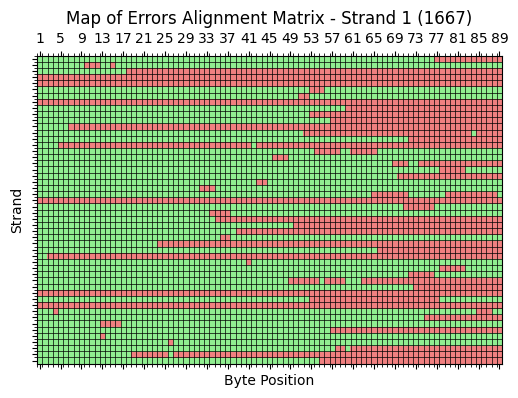

[ 488  274 1187 1145  942  724   78  892  426  251 1034  948  650  339
 1202 1079   85   11  593  577  515  468  105  801  621  711 1205  121
  348 1057  705  609  326  792  712  998  889  765   99 1150  124  172
  288  945  534 1006  658 1303  109  686]


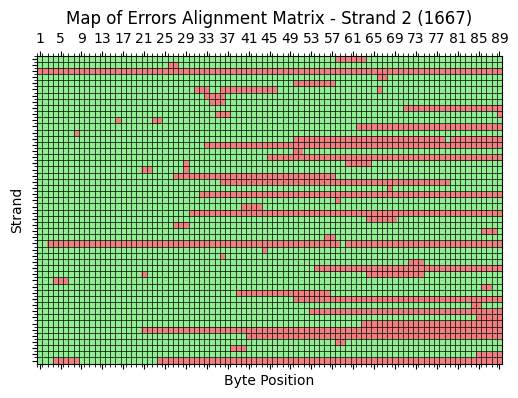

6.638361638361638


In [31]:
def get_error_lengths(maps):
    error_length=[]
    for m in maps:
        error_counter=0
        for i in m:
            if i==1:
                error_counter+=1
            if i==0 and error_counter>0:
                error_length.append(error_counter)
                error_counter=0
    return error_length


dna_main_df = pd.read_pickle("231220_main_dna.pickle")
dna_df_dict=separate_master_data_frame(dna_main_df,None)
#rna/dna soft decoding data
bonito_viterbi_dna = dna_df_dict["hedges"]
bonito_viterbi_dna=bonito_viterbi_dna[bonito_viterbi_dna["encoder::byte_error_map"]==True]

error_length=[]
for i in range(1,3):
    baseline = bonito_viterbi_dna[bonito_viterbi_dna.experiment_path.str.match(".*full_1667_hedges_strand_?{}_.*".format(i))]
    baseline_maps = baseline["payload::hedges::error_maps"].iloc[0]
    error_length+=get_error_lengths(baseline_maps)
    num_maps=np.random.choice(len(baseline_maps),50)
    print(num_maps)
    success_matrix=np.ndarray((len(num_maps),len(baseline_maps[0])))
    for j_index,j in enumerate(num_maps):
        for k in range(success_matrix.shape[1]):
            success_matrix[j_index,k]=baseline_maps[j][k]
    cmap = matplotlib.colors.ListedColormap(['lightgreen','lightcoral',])
    fig, ax = plt.subplots(figsize=(6, 4))
    im = ax.matshow(success_matrix,interpolation='nearest',aspect='auto',cmap=cmap)
    # Major ticks
    ax.set_xticks(np.arange(0, success_matrix.shape[1], 4))
    ax.set_xticks(np.arange(-.5, success_matrix.shape[1]-0.5, 1), minor=True)
    ax.set_yticks(np.arange(-0.5,success_matrix.shape[0]-0.5,1),minor=True)
    ax.set_yticks(np.arange(0, success_matrix.shape[0], 1))
    ax.set_xticklabels(np.arange(1, success_matrix.shape[1]+1, 4))
    #ax.set_yticklabels(np.arange(1, success_matrix.shape[0]+1, 1))
    ax.yaxis.set_tick_params(labelleft=False)
    ax.grid(which='minor', color='k', linestyle='-', linewidth=0.5)
    #titles
    ax.set_title("Map of Errors Alignment Matrix - Strand {} (1667)".format(i))
    ax.set_xlabel("Byte Position")
    ax.set_ylabel("Strand")
    plt.savefig("strand_{}_error_map_alignment_matrix.png".format(i),format="png",dpi=1200)
    plt.show()
print(np.mean(error_length))

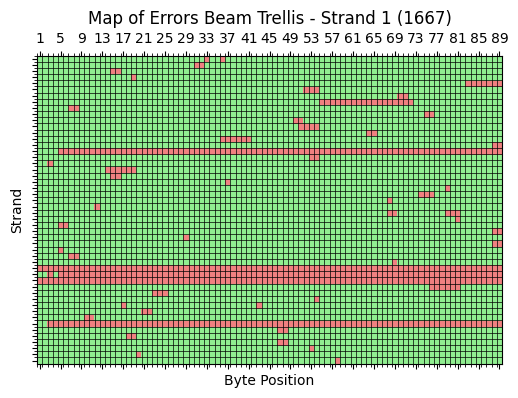

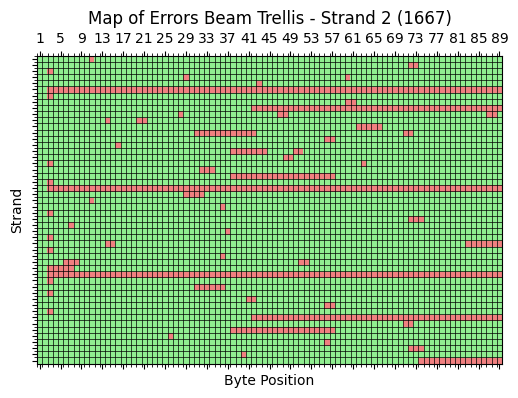

2.6914119359534205


In [32]:
dna_main_df = pd.read_pickle("231220_main_dna.pickle")
dna_df_dict=separate_master_data_frame(dna_main_df,None)
#rna/dna soft decoding data
bonito_viterbi_dna = dna_df_dict["hedges"]
bonito_viterbi_dna=bonito_viterbi_dna[bonito_viterbi_dna["encoder::byte_error_map"]==True]

error_length=[]
for i in range(1,3):
    baseline = bonito_viterbi_dna[bonito_viterbi_dna.experiment_path.str.match(".*231206_dna_datastorage_1667_batch_full_1667_hedges_beam_strand{}.*".format(i))]
    baseline_maps = baseline["payload::hedges::error_maps"].iloc[0]
    error_length+=get_error_lengths(baseline_maps)
    num_maps=np.random.choice(len(baseline_maps),50)
    success_matrix=np.ndarray((len(num_maps),len(baseline_maps[0])))
    for j_index,j in enumerate(num_maps):
        for k in range(success_matrix.shape[1]):
            success_matrix[j_index,k]=baseline_maps[j][k]
    cmap = matplotlib.colors.ListedColormap(['lightgreen','lightcoral',])
    fig, ax = plt.subplots(figsize=(6, 4))
    im = ax.matshow(success_matrix,interpolation='nearest',aspect='auto',cmap=cmap)
    # Major ticks
    ax.set_xticks(np.arange(0, success_matrix.shape[1], 4))
    ax.set_xticks(np.arange(-.5, success_matrix.shape[1]-0.5, 1), minor=True)
    ax.set_yticks(np.arange(-0.5,success_matrix.shape[0]-0.5,1),minor=True)
    ax.set_yticks(np.arange(0, success_matrix.shape[0], 1))
    ax.set_xticklabels(np.arange(1, success_matrix.shape[1]+1, 4))
    #ax.set_yticklabels(np.arange(1, success_matrix.shape[0]+1, 1))
    ax.yaxis.set_tick_params(labelleft=False)
    ax.grid(which='minor', color='k', linestyle='-', linewidth=0.5)
    #titles
    ax.set_title("Map of Errors Beam Trellis - Strand {} (1667)".format(i))
    ax.set_xlabel("Byte Position")
    ax.set_ylabel("Strand")
    plt.savefig("strand_{}_error_map_beam.png".format(i),format="png",dpi=1200)
    plt.show()
    plt.show()
print(np.mean(error_length))